In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import pandas as pd
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300

In [2]:
# load transformer training dynamics info
transformer_df = pd.read_csv("../data/transformers_sweep_data_cutoffs_vecs.csv")
vector_columns = [
    'ood_test_acc_vector',
    'indist_test_acc_vector', 
    'train_acc_vector', 
    'ood_test_loss_vector',
    'indist_test_loss_vector', 
    'train_loss_vector',
    'datapoints_seen_vector'
]

for col in vector_columns:
    if col in transformer_df.columns:
        transformer_df[col] = transformer_df[col].apply(literal_eval)

transformer_df['final_ood_test_acc'] = transformer_df['ood_test_acc_vector'].apply(lambda x: x[-1] if x else None)

#### Bar Plots -- LSTMs vs Transformers, Transformers Breakdown, Rdm Impact

In [3]:
lstm_df = pd.read_csv("../data/lstms_sweep_data_cutoffs_vecs.csv")

for col in vector_columns:
    if col in lstm_df.columns:
        lstm_df[col] = lstm_df[col].apply(literal_eval)

lstm_df['final_ood_test_acc'] = lstm_df['ood_test_acc_vector'].apply(lambda x: x[-1] if x else None)

In [4]:
transformer_df['final_ood_test_acc'] = transformer_df['ood_test_acc_vector'].apply(lambda x: x[-1] if x else None)
lstm_df['final_ood_test_acc'] = lstm_df['ood_test_acc_vector'].apply(lambda x: x[-1] if x else None)

transformer_df['pct_indist_after_inx_10_>0.99'] = transformer_df['indist_test_acc_vector'].apply(lambda x: np.mean(np.array(x[20:]) > 0.99))
lstm_df['pct_indist_after_inx_10_>0.99'] = lstm_df['indist_test_acc_vector'].apply(lambda x: np.mean(np.array(x[20:]) > 0.99))

# models achieving >99% accuracy more than 85% of the time 
lstm_df['converged'] = lstm_df['pct_indist_after_inx_10_>0.99'] >= 0.85
transformer_df['converged'] = transformer_df['pct_indist_after_inx_10_>0.99'] >= 0.85

lstm_filtered = lstm_df[lstm_df['converged']].copy()
transformer_filtered = transformer_df[transformer_df['converged']].copy()
assert(len(transformer_filtered) == len(transformer_df))

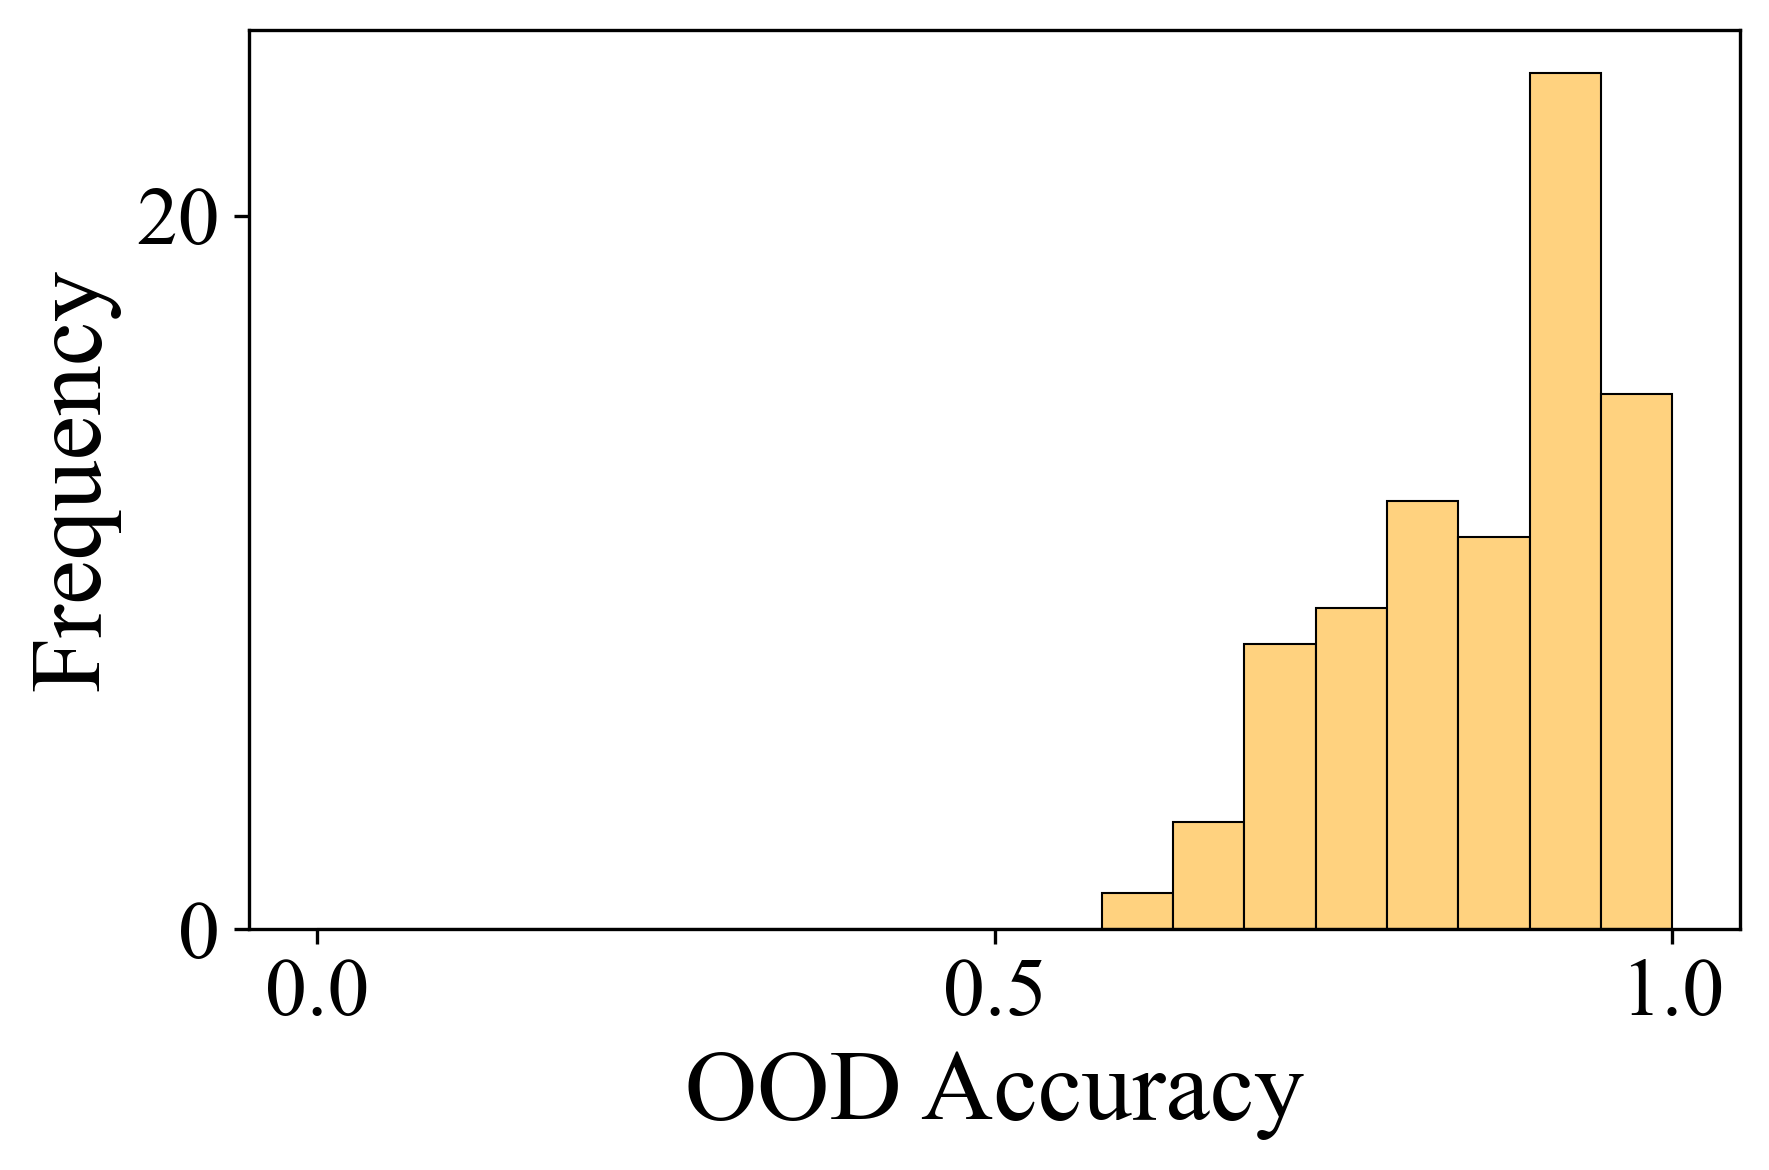

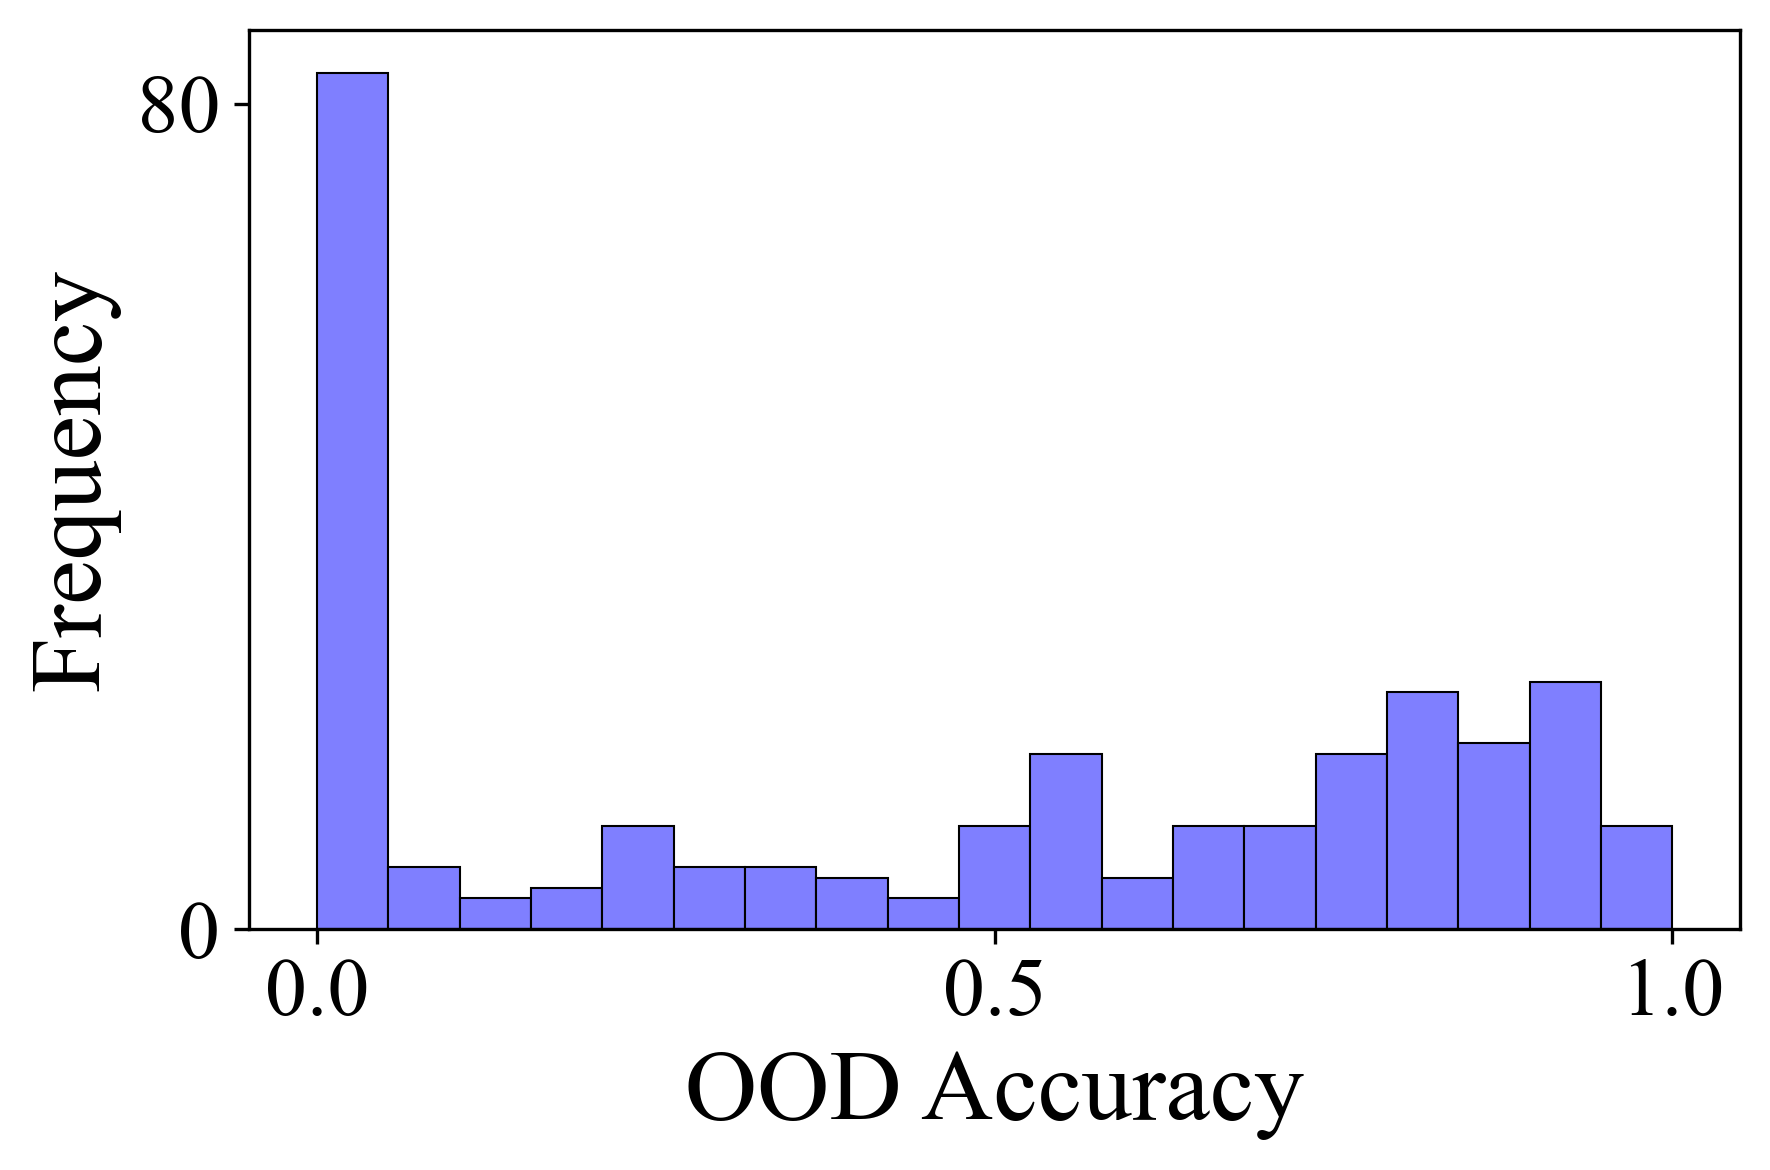

In [5]:
def get_acc_hist(lstm:bool, color:str):
    x_bins = np.linspace(0, 1, 20)
    if lstm: 
        plt_df = lstm_filtered
    else: 
        plt_df = transformer_filtered
    plt.figure(figsize=(6, 4))
    plt.hist(plt_df['final_ood_test_acc'], bins=x_bins, color=color, edgecolor='black', linewidth=0.5)
    plt.xlabel('OOD Accuracy', fontsize=24)
    plt.ylabel('Frequency', fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, np.floor(plt.ylim()[1]/10)*10])
    plt.tight_layout()
    plt.show()

get_acc_hist(lstm=True, color='#ffd27f')
get_acc_hist(lstm=False, color='#7f7fff')

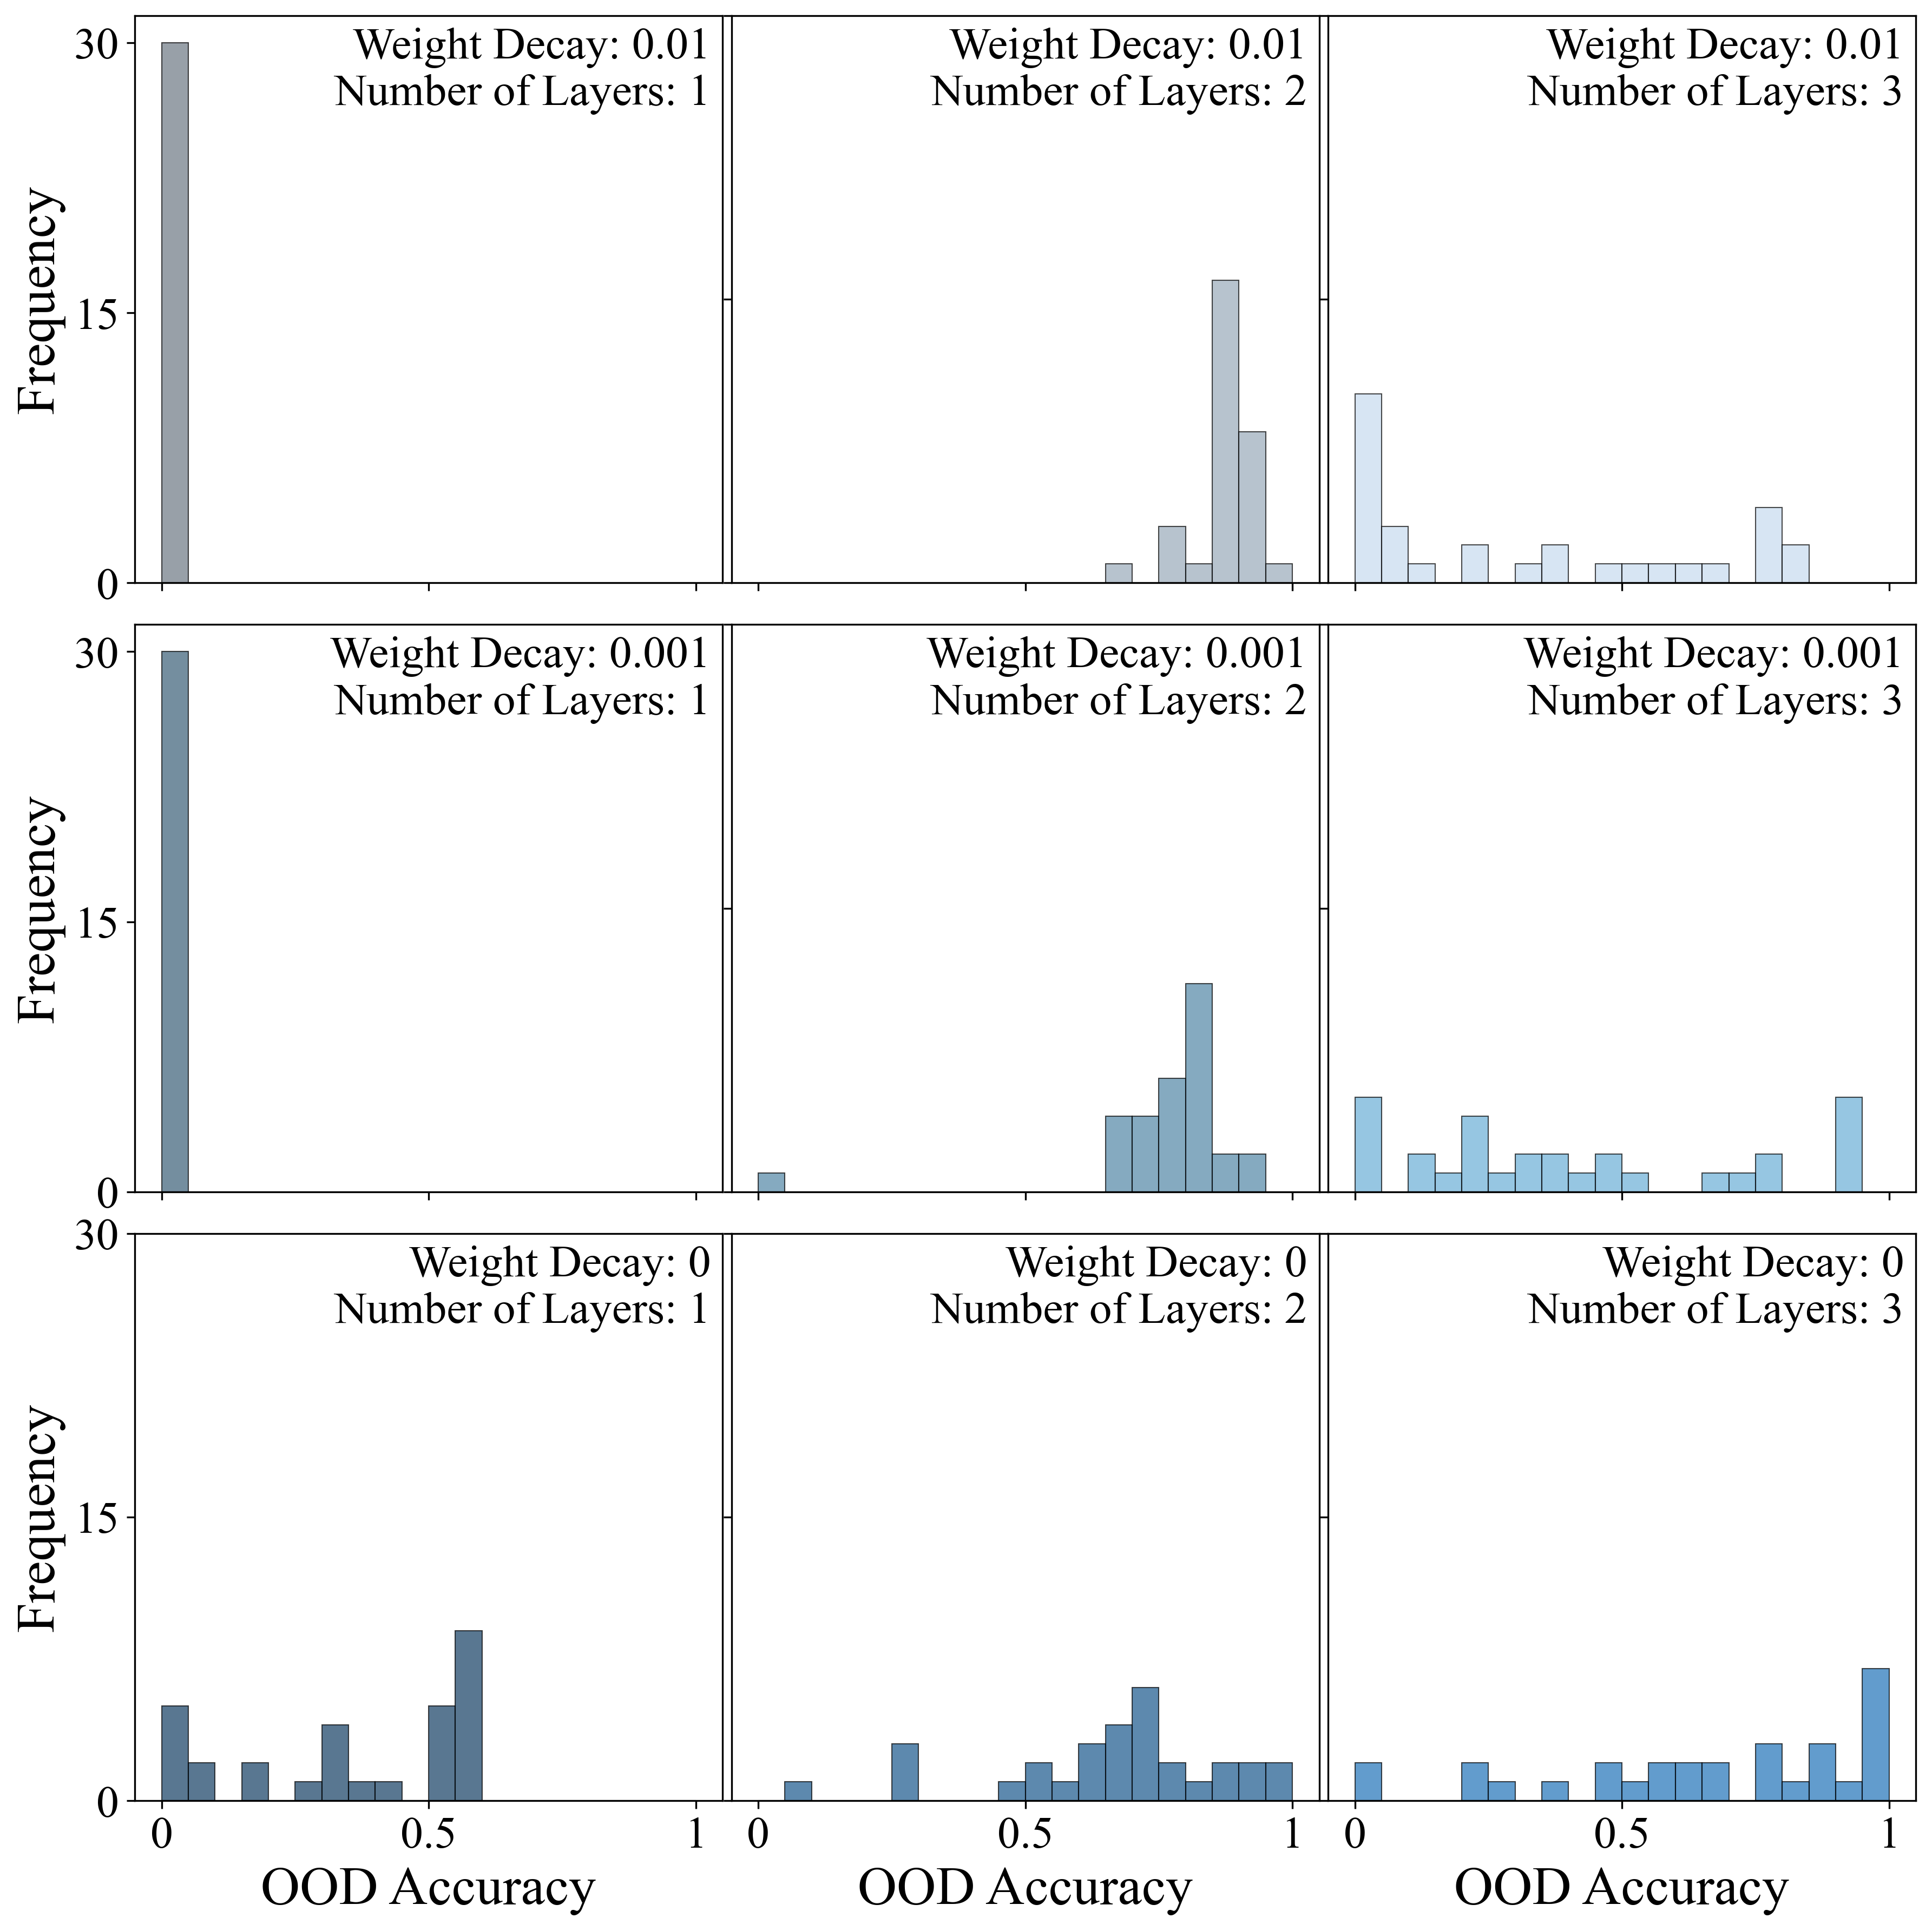

In [6]:
def get_plt_grid():
    # 3x3 subplot figure 
    _, axes = plt.subplots(3, 3, figsize=(12, 12))

    wd_values = [0.01, 0.001, 0]
    n_layer_values = [1, 2, 3]

    bins = np.linspace(0, 1, 21)

    colors = ['#6d7883', '#99aaba', '#c6dbef', 
              '#395f76', '#5287a6', '#6aaed6',
              '#133e63', '#19578c', '#2072b8']
    
    for i, wd in enumerate(wd_values):
        for j, n_layer in enumerate(n_layer_values):
            ax = axes[i, j]
            
            subset = transformer_filtered[(transformer_filtered['wd'] == wd) & 
                                        (transformer_filtered['n_layer'] == n_layer)]
            
            if len(subset) > 0:
                ax.hist(subset['final_ood_test_acc'], bins=bins, color=colors[i*3 + j], 
                    edgecolor='black', linewidth=0.5, alpha=0.7)
            
            # labels and title
            if i == 2: 
                ax.set_xlabel('OOD Accuracy', fontsize=24)
            if j == 0:
                ax.set_ylabel('Frequency', fontsize=24)
                
            ax.text(0.98, 0.98, f'Weight Decay: {wd}\nNumber of Layers: {n_layer}', 
                   transform=ax.transAxes, fontsize=20,
                   ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
            
            ax.set_xlim(-0.05, 1.05) 
            
            ax.set_yticks([0, 15, 30])
            ax.set_xticks([0, 0.5, 1])
            ax.set_xticklabels(['0', '0.5', '1'])
            
            if j == 0: # first col
                ax.tick_params(axis='y', labelsize=20)
            else:
                ax.tick_params(axis='y', labelleft=False)
                
            if i == 2: # last row
                ax.tick_params(axis='x', labelsize=20)
            else:
                ax.tick_params(axis='x', labelbottom=False)

            ax.grid(False)

    plt.tight_layout(h_pad=0.05, w_pad=0.05)
    plt.show()

get_plt_grid()

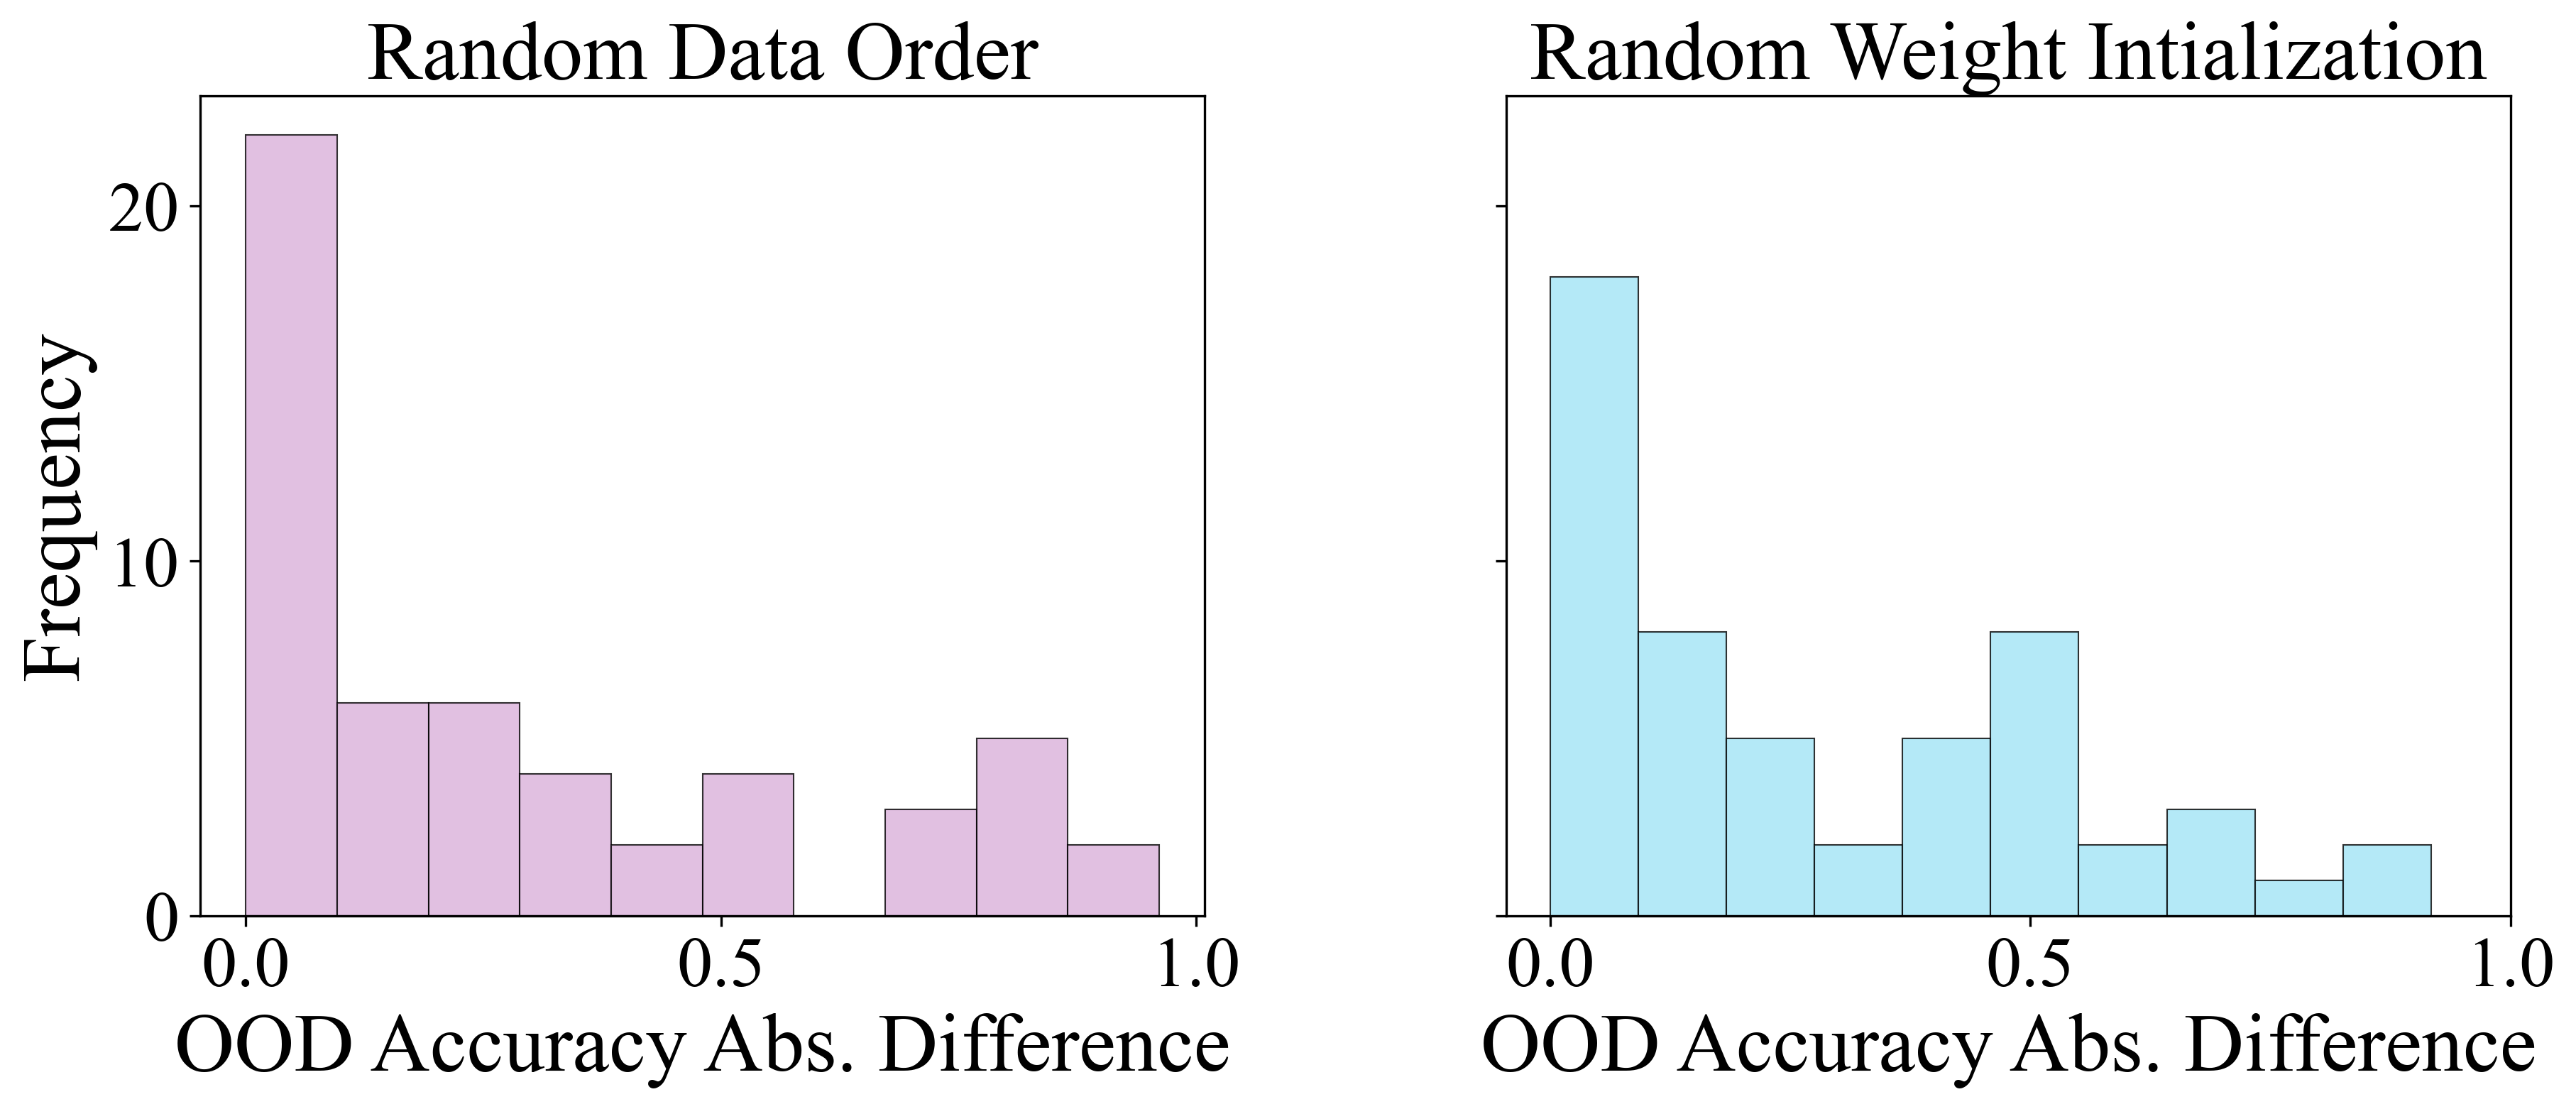

In [7]:
def get_rdm_seed_impact(df):
    np.random.seed(29)
    unique_rdm = df['rdm_seed'].unique()
    selected_rdm = np.random.choice(unique_rdm, size=3)
    filtered_df = df[df['rdm_seed'].isin(selected_rdm)]

    param_cols = [c for c in ['lr', 'wd', 'opt', 'batch_size', 'n_layer', 'n_head'] if c in df.columns]

    # shuffle_seed ranges: vary shuffle_seed, hold random seed constant
    group_cols_shuffle = param_cols + ['rdm_seed']
    shuffle_ranges = (
        filtered_df
        .groupby(group_cols_shuffle)['final_ood_test_acc']
        .agg(lambda x: x.max() - x.min())
        .values
    )

    # rdm_seed ranges: vary random seed, hold shuffle seed constant
    group_cols_rdm = param_cols + ['shuffle_seed']
    rdm_ranges = (
        filtered_df
        .groupby(group_cols_rdm)['final_ood_test_acc']
        .agg(lambda x: x.max() - x.min())
        .values
    )

    _, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True, gridspec_kw={'wspace': 0.3})

    color1 = '#DAB1DA'
    color2 = '#a2e4f5'

    axes[0].hist(shuffle_ranges, bins=10, color=color1, alpha=0.8, edgecolor='black', linewidth=0.5)
    axes[0].set_title('Random Data Order', fontsize=28)
    axes[0].set_xlabel('OOD Accuracy Abs. Difference', fontsize=28)
    axes[0].set_ylabel('Frequency', fontsize=28)
    axes[0].set_yticks([0, 10, 20])
    axes[0].tick_params(axis='y', labelsize=24)
    axes[0].set_xticks([0, 0.5, 1])
    axes[0].tick_params(axis='x', labelsize=24)

    axes[1].hist(rdm_ranges, bins=10, color=color2, alpha=0.8, edgecolor='black', linewidth=0.5)
    axes[1].set_title('Random Weight Intialization', fontsize=28)
    axes[1].set_xlabel('OOD Accuracy Abs. Difference', fontsize=28)
    axes[1].set_xticks([0, 0.5, 1])
    axes[1].tick_params(axis='x', labelsize=24)

    plt.show()

get_rdm_seed_impact(transformer_df)

#### Violin Plots -- Impact of Width & WD

In [8]:
from scipy.stats import mannwhitneyu

transformer_df['wd_group'] = transformer_df['wd'].apply(lambda x: '= 0' if x == 0 else '≠ 0')

In [9]:
def get_mannwhitneyu(group_by_wd:bool):
    for n_layer in [1, 2, 3]:
        if group_by_wd:
            wd_zero = transformer_df[(transformer_df['n_layer'] == n_layer) & 
                                        (transformer_df['wd_group'] == "= 0")]['final_ood_test_acc']
            wd_nonzero = transformer_df[(transformer_df['n_layer'] == n_layer) & 
                                            (transformer_df['wd_group'] == "≠ 0")]['final_ood_test_acc']
            
            statistic, p_value = mannwhitneyu(wd_zero, wd_nonzero, alternative='two-sided')
        else:
            n_head_2 = transformer_df[(transformer_df['n_layer'] == n_layer) & 
                                        (transformer_df['n_head'] == 2)]['final_ood_test_acc']
            n_head_4 = transformer_df[(transformer_df['n_layer'] == n_layer) & 
                                        (transformer_df['n_head'] == 4)]['final_ood_test_acc']
            
            statistic, p_value = mannwhitneyu(n_head_2, n_head_4, alternative='two-sided')
        
        print(f"{'[wd]' if group_by_wd else '[n_head]'} N_layer {n_layer}: U-stat = {statistic:.2f}, p-value = {p_value:.4f}")

get_mannwhitneyu(group_by_wd=True)
get_mannwhitneyu(group_by_wd=False)

[wd] N_layer 1: U-stat = 1673.00, p-value = 0.0000
[wd] N_layer 2: U-stat = 418.50, p-value = 0.0000
[wd] N_layer 3: U-stat = 1347.00, p-value = 0.0001
[n_head] N_layer 1: U-stat = 982.00, p-value = 0.7705
[n_head] N_layer 2: U-stat = 1252.00, p-value = 0.0538
[n_head] N_layer 3: U-stat = 1152.00, p-value = 0.2619


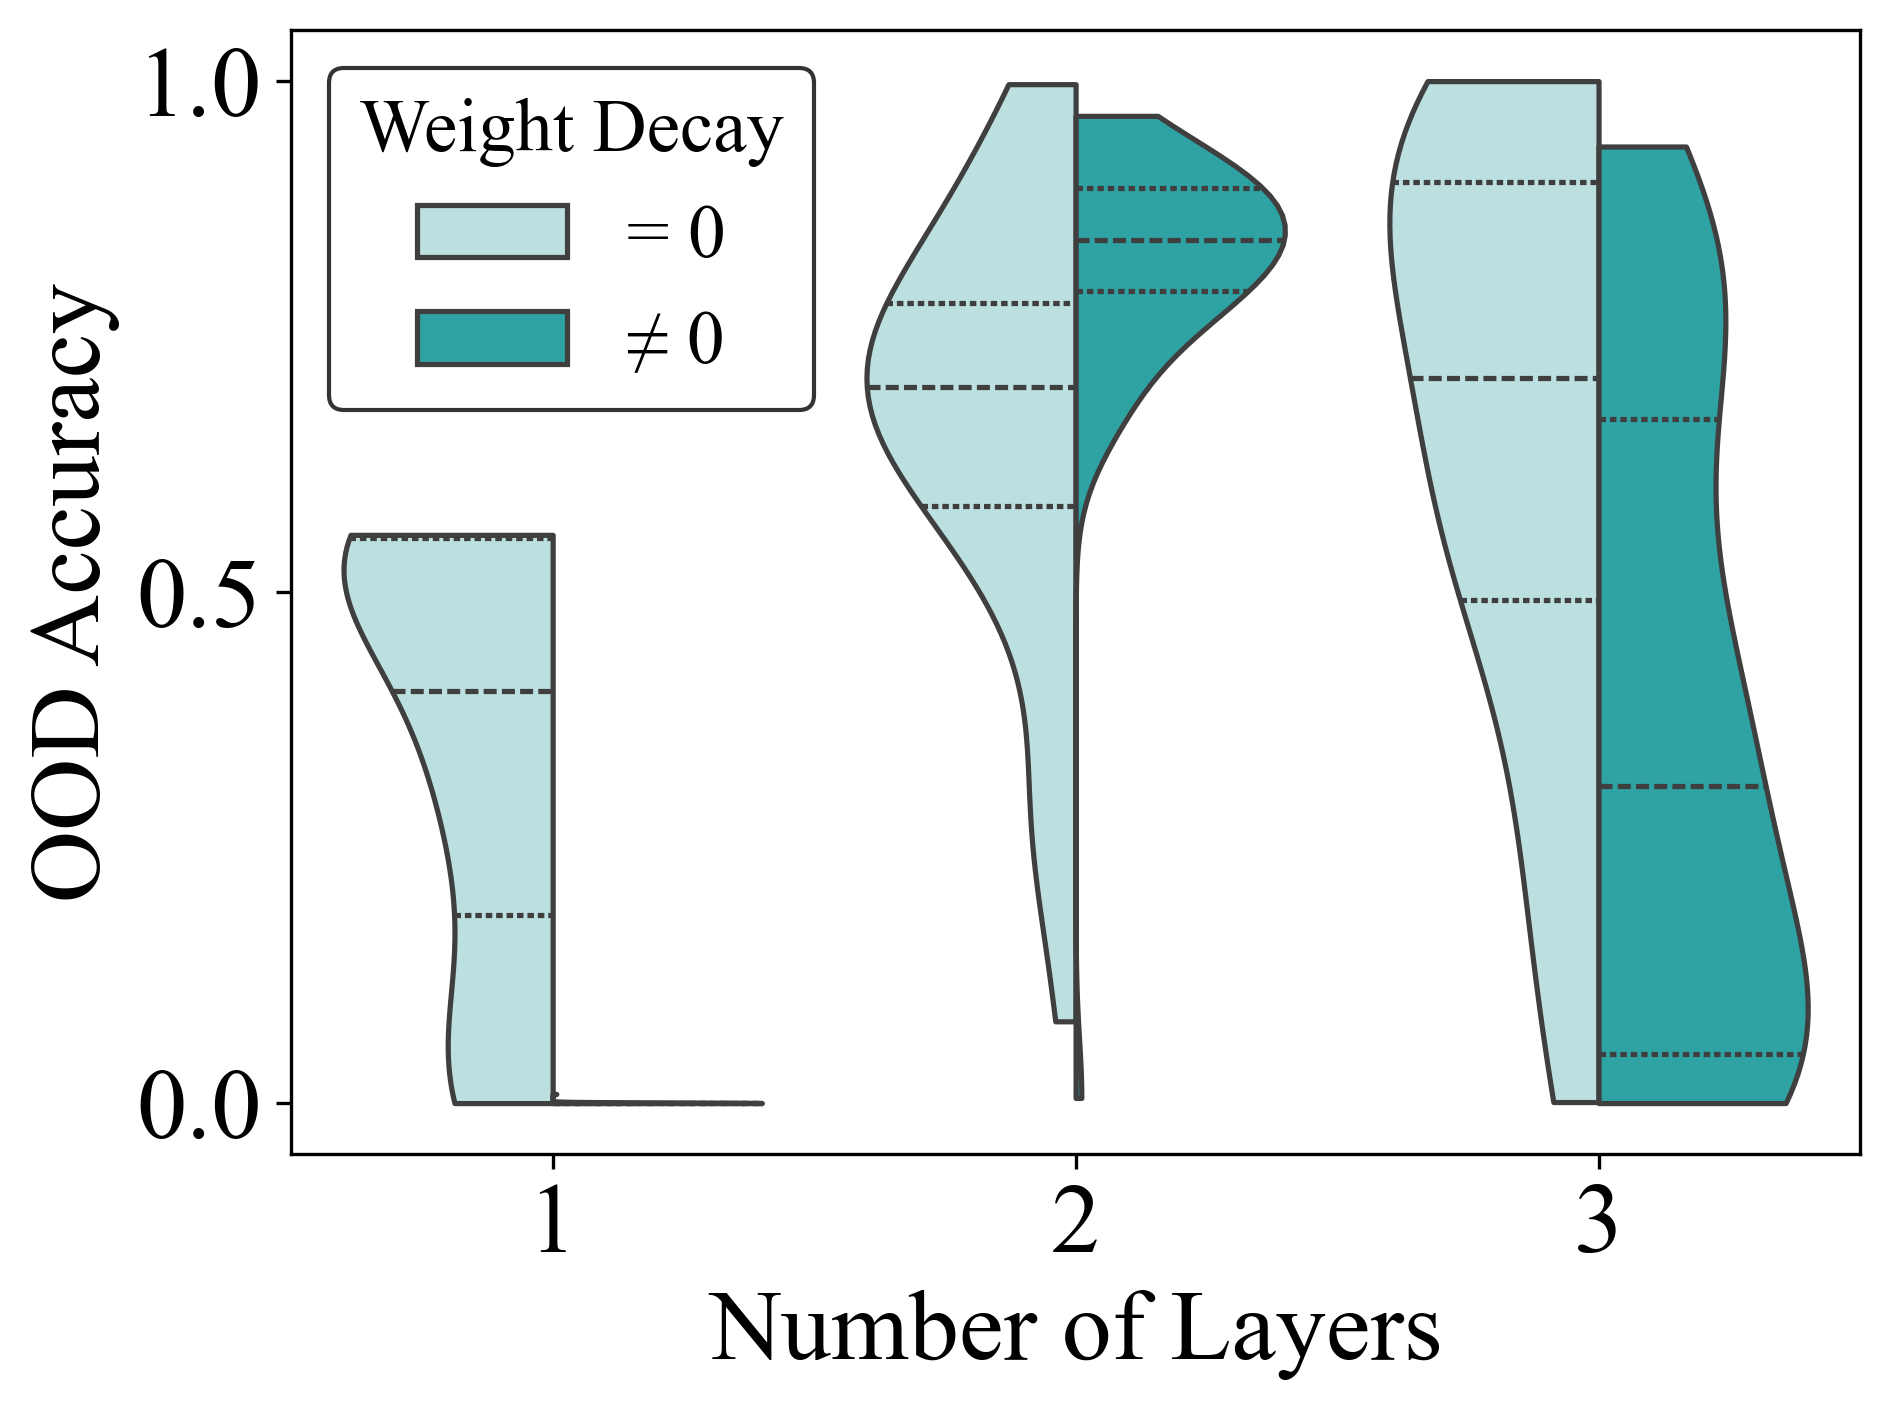

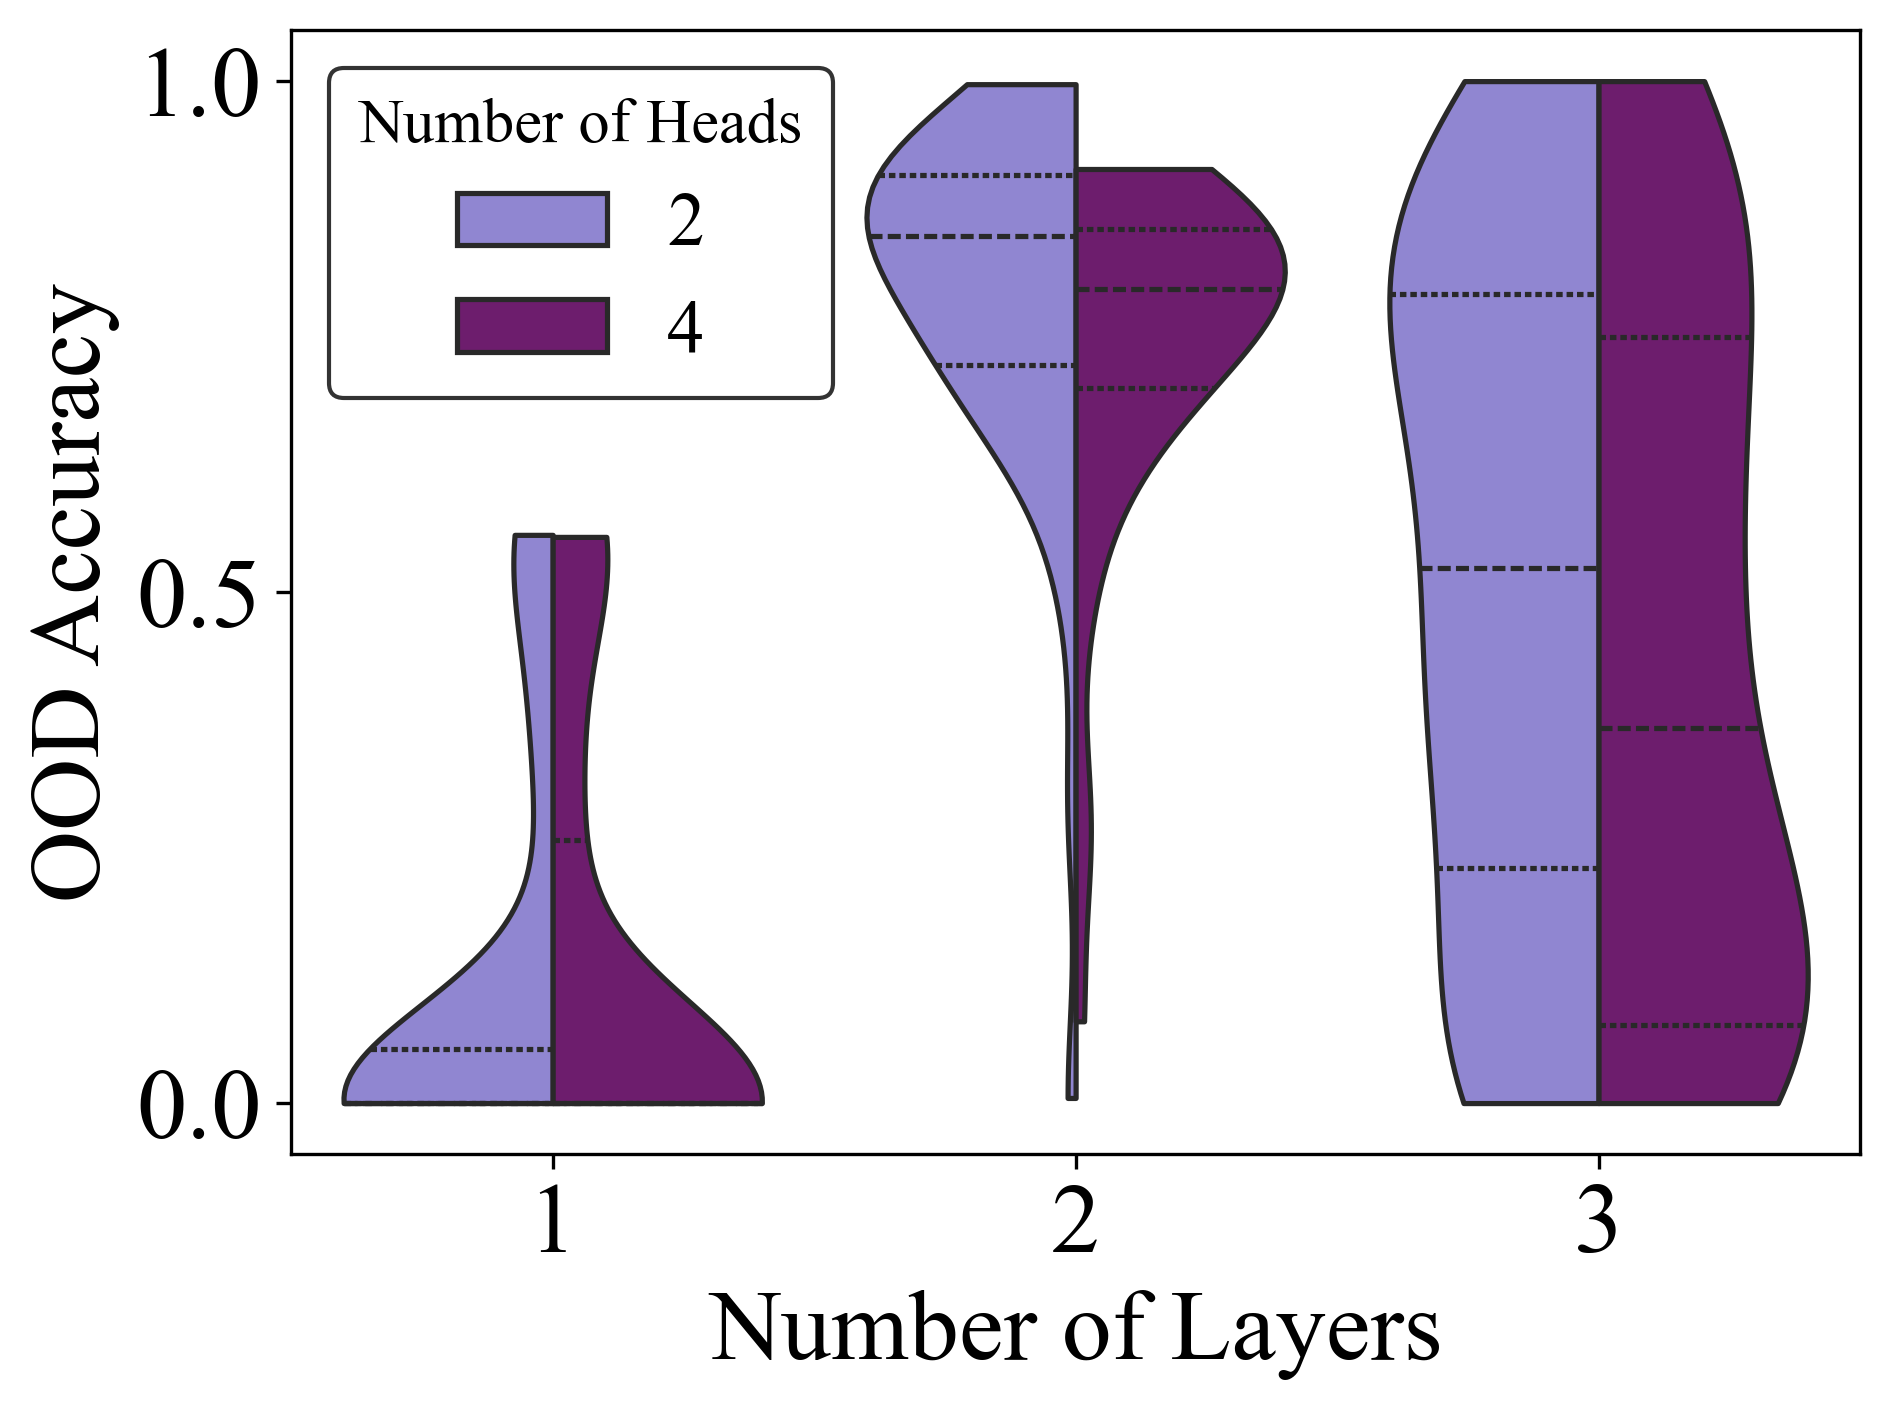

In [10]:
def get_violins(group_by:str, colors:list, title:str):
    if group_by == "wd_group":
        hue_order = ['= 0', '≠ 0']
    else:
        hue_order = None

    ax = sns.violinplot(data=transformer_df, 
                    x='n_layer', 
                    y='final_ood_test_acc',
                    hue=group_by,
                    hue_order=hue_order,
                    density_norm="width", 
                    split=True, 
                    palette=colors, 
                    inner="quartile", 
                    cut=0)

    ax.set_xlabel('Number of Layers', fontsize=24)
    ax.set_ylabel('OOD Accuracy', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    legend = ax.legend(title=title, fontsize=18, title_fontsize=15 if group_by == "n_head" else 18)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1)

    plt.yticks([0, 0.5, 1])
    plt.tight_layout()
    plt.show()

get_violins(group_by="wd_group", colors=['#b6e6e6', '#1bb5b8'], title="Weight Decay")
get_violins(group_by="n_head", colors=['#877add', '#7a107a'], title="Number of Heads")

#### Accuracy Over Time -- Heatmaps, Scatterplot

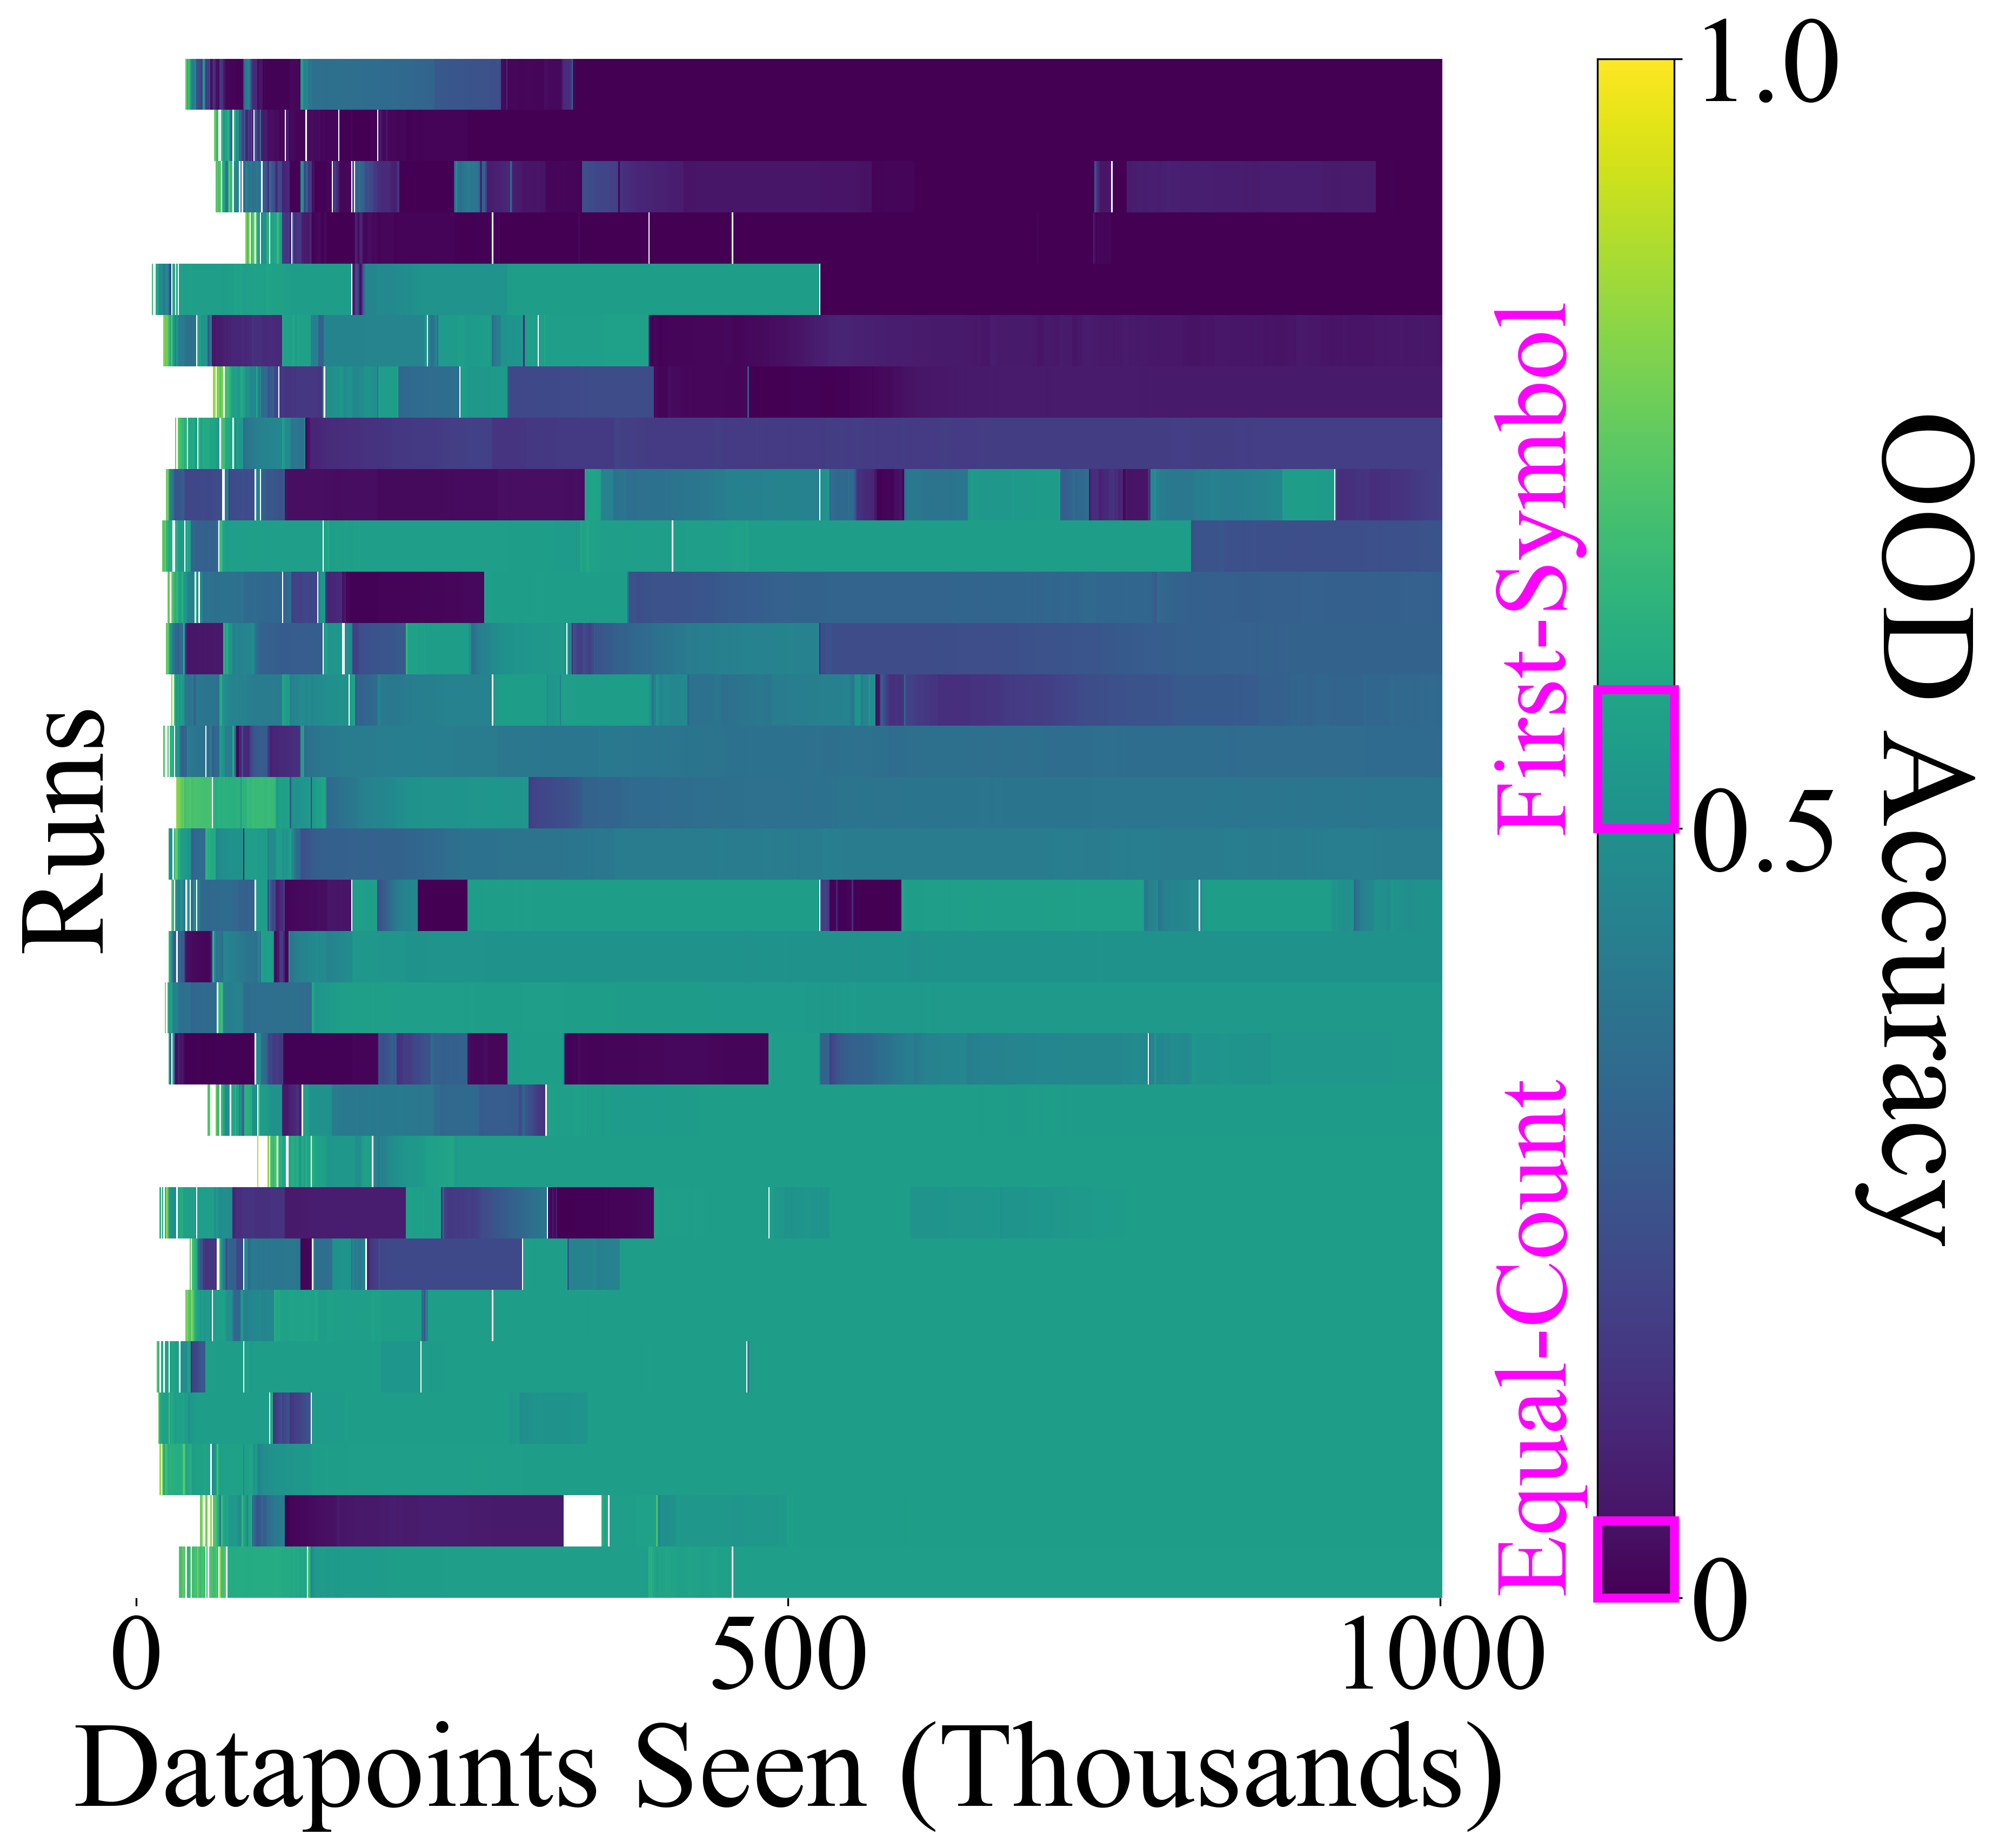

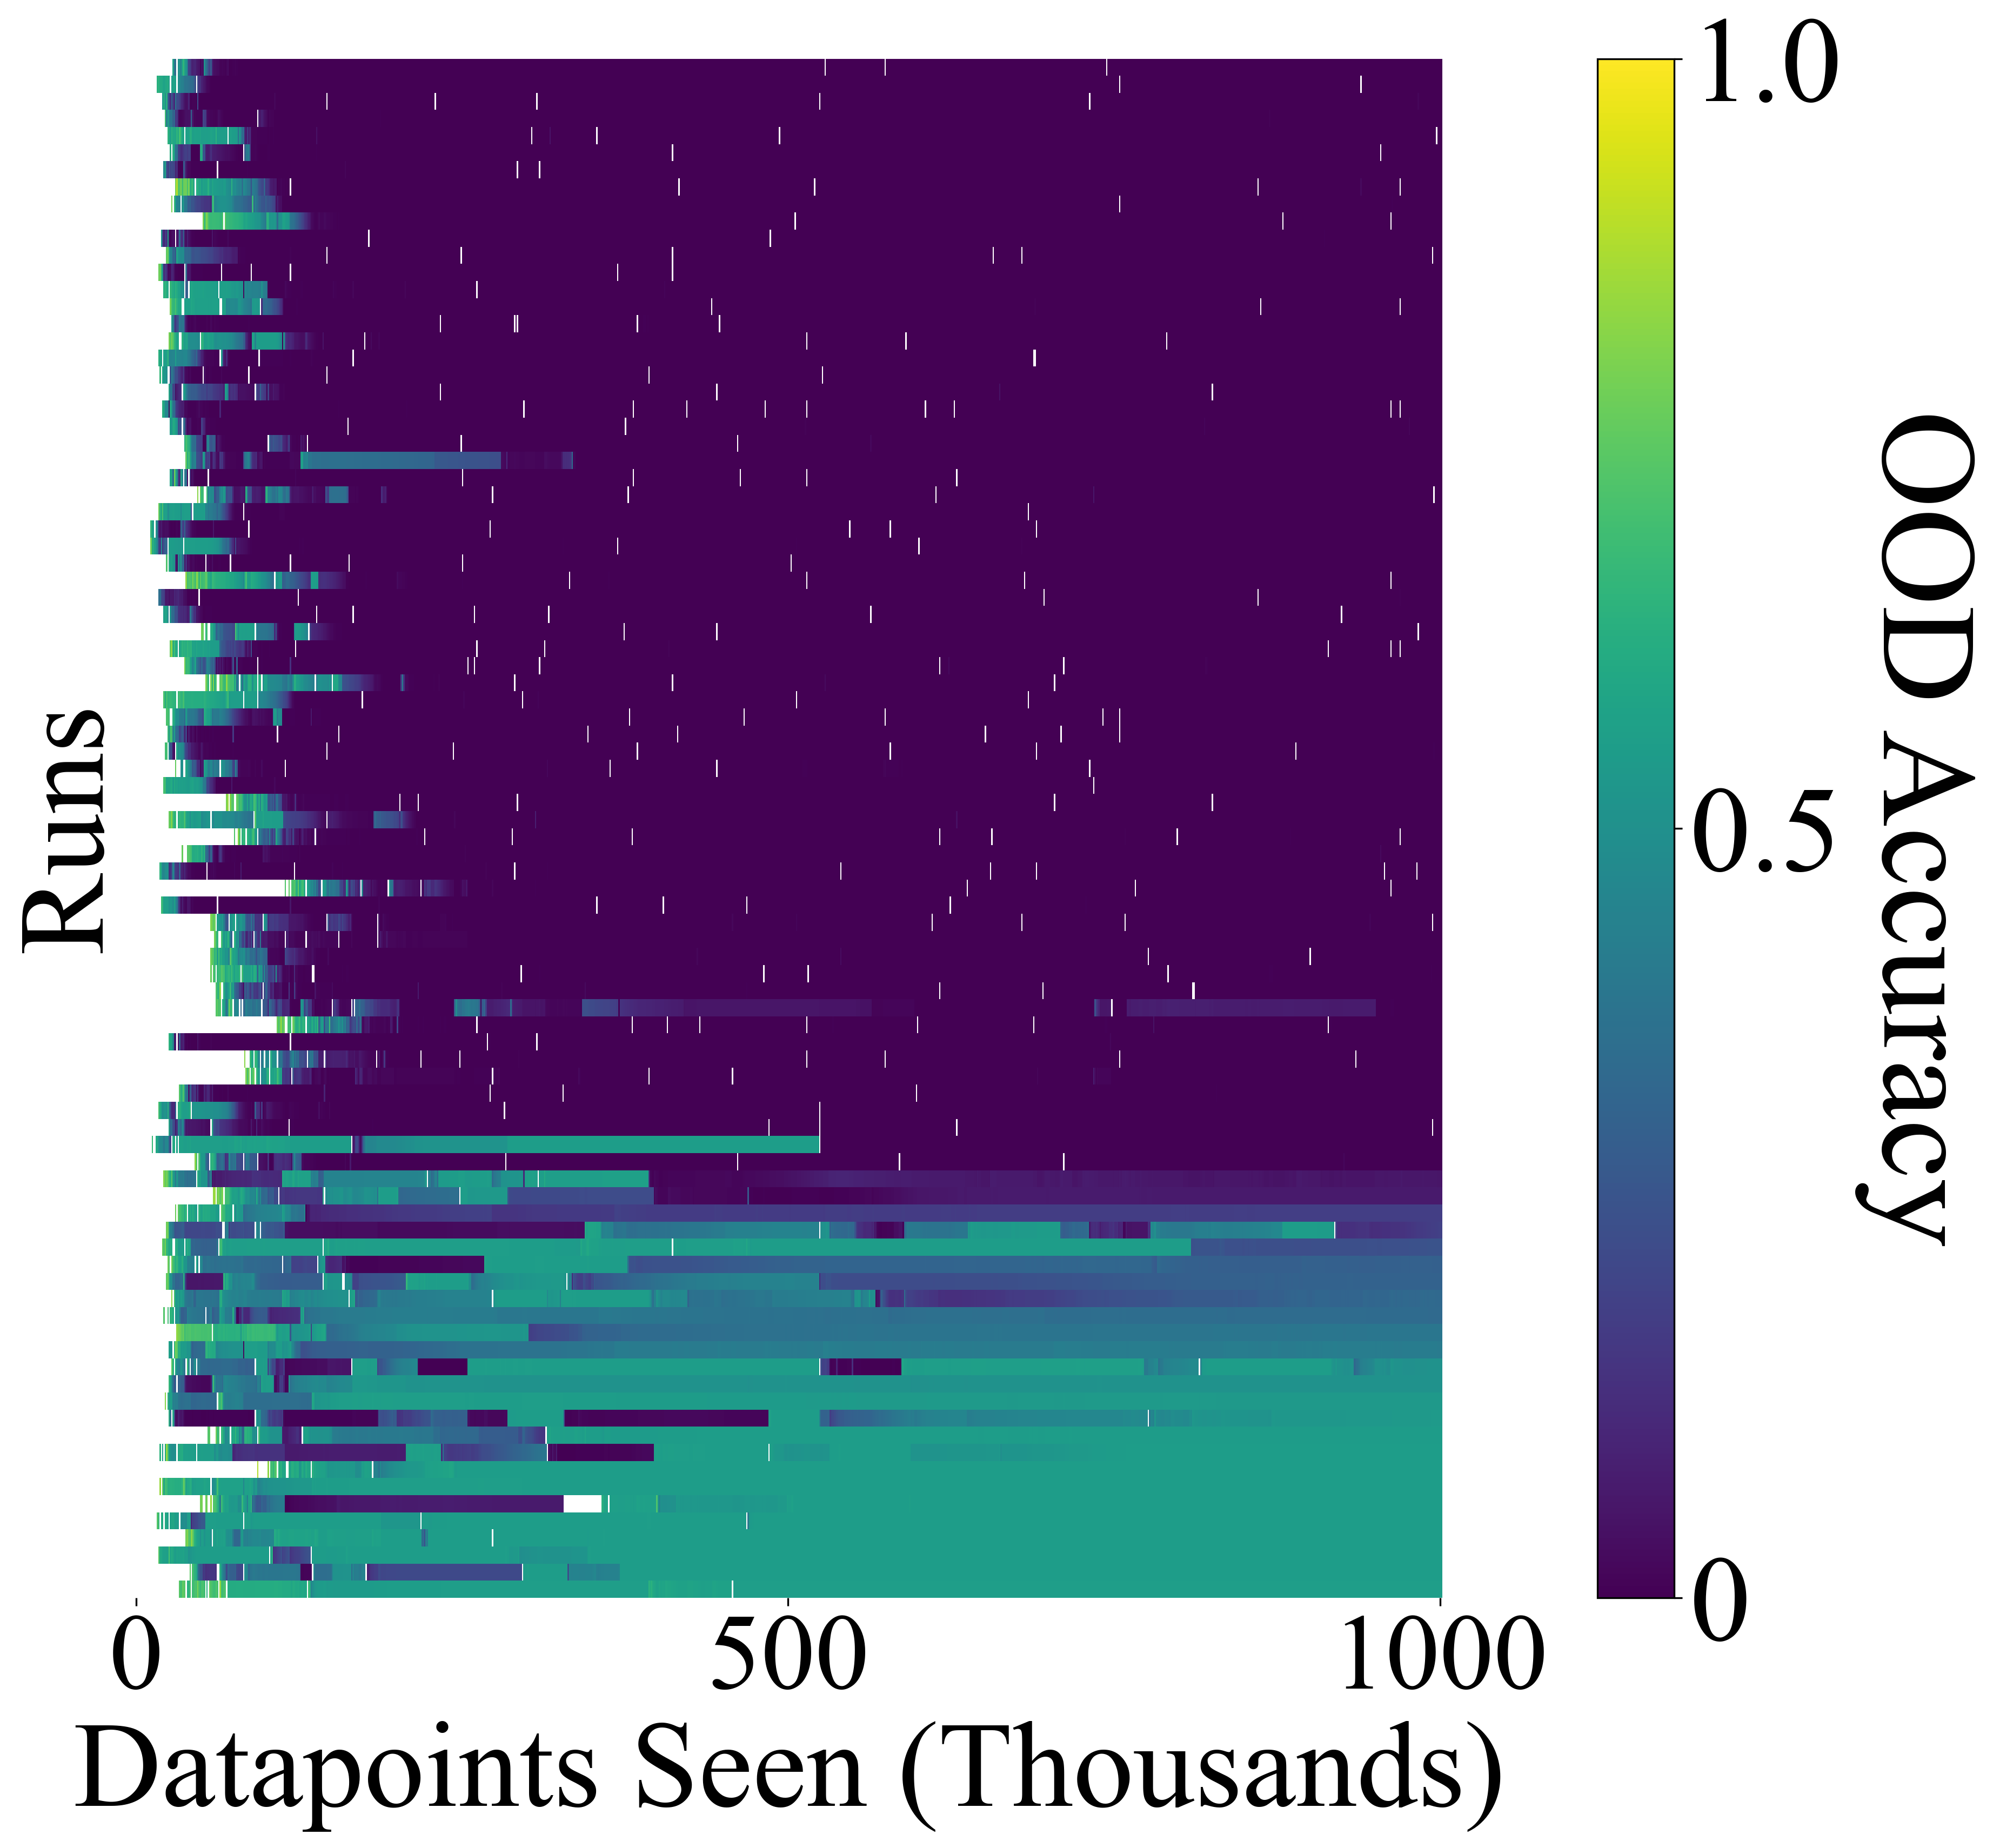

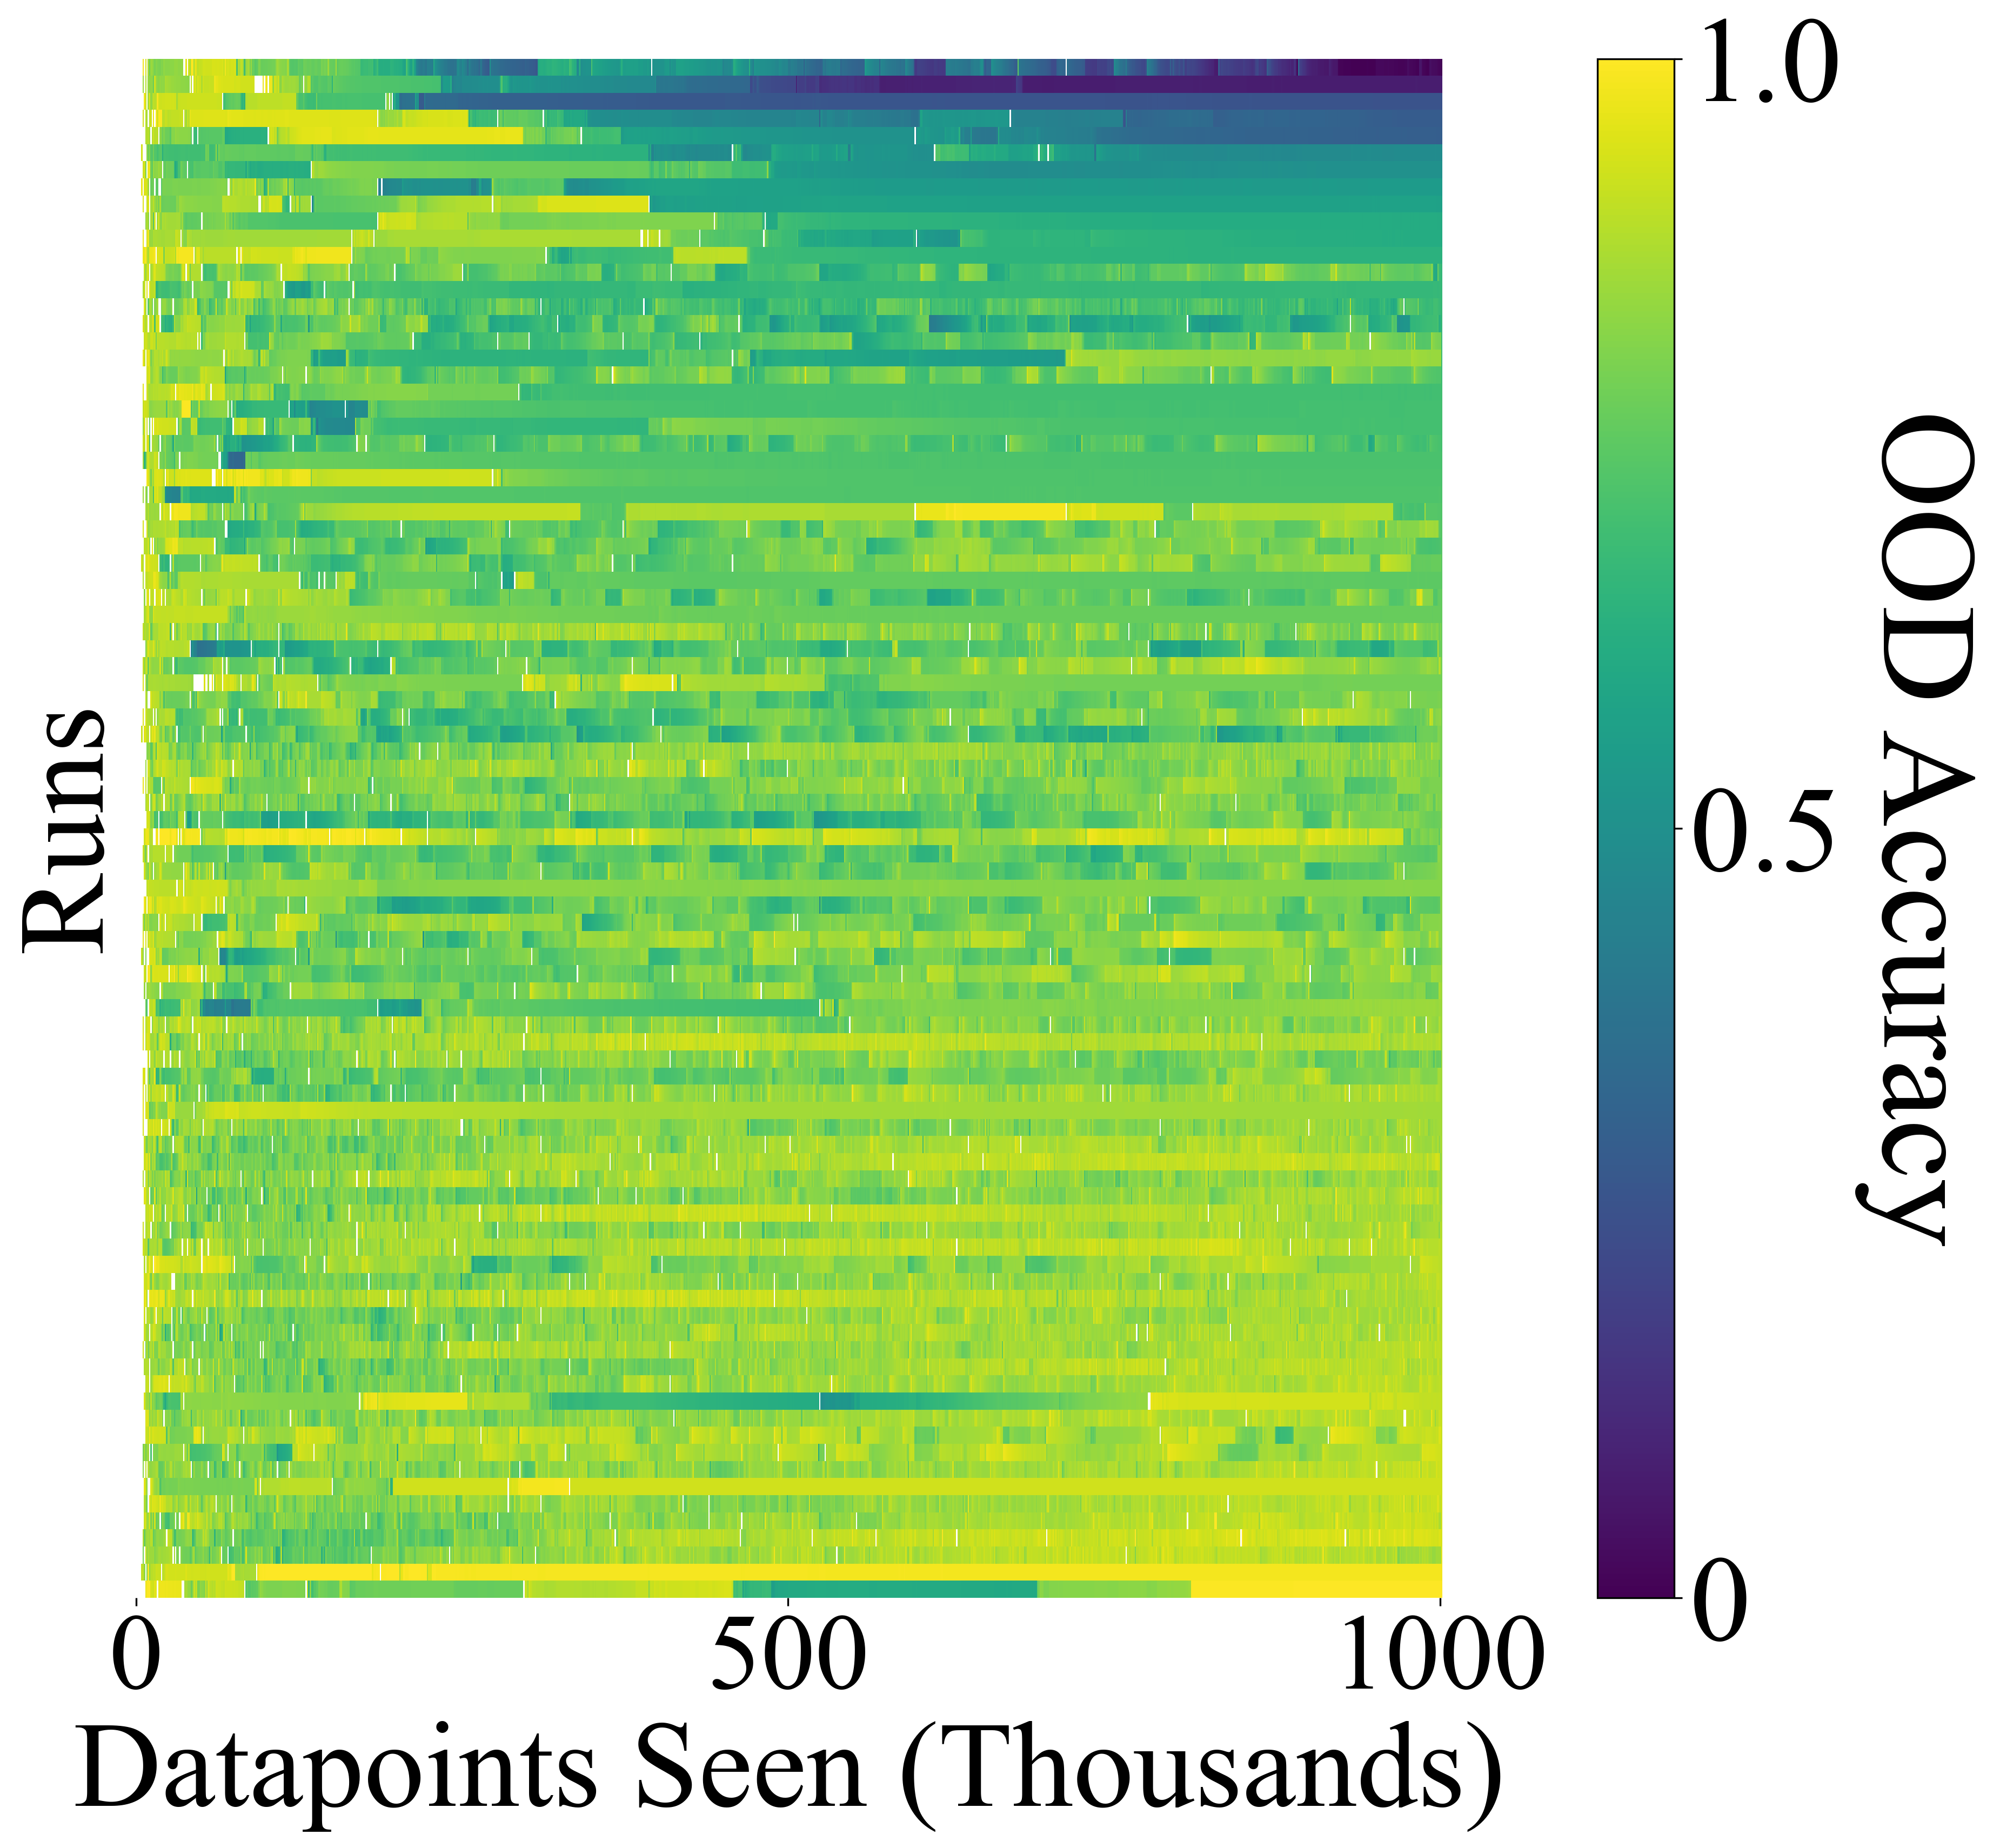

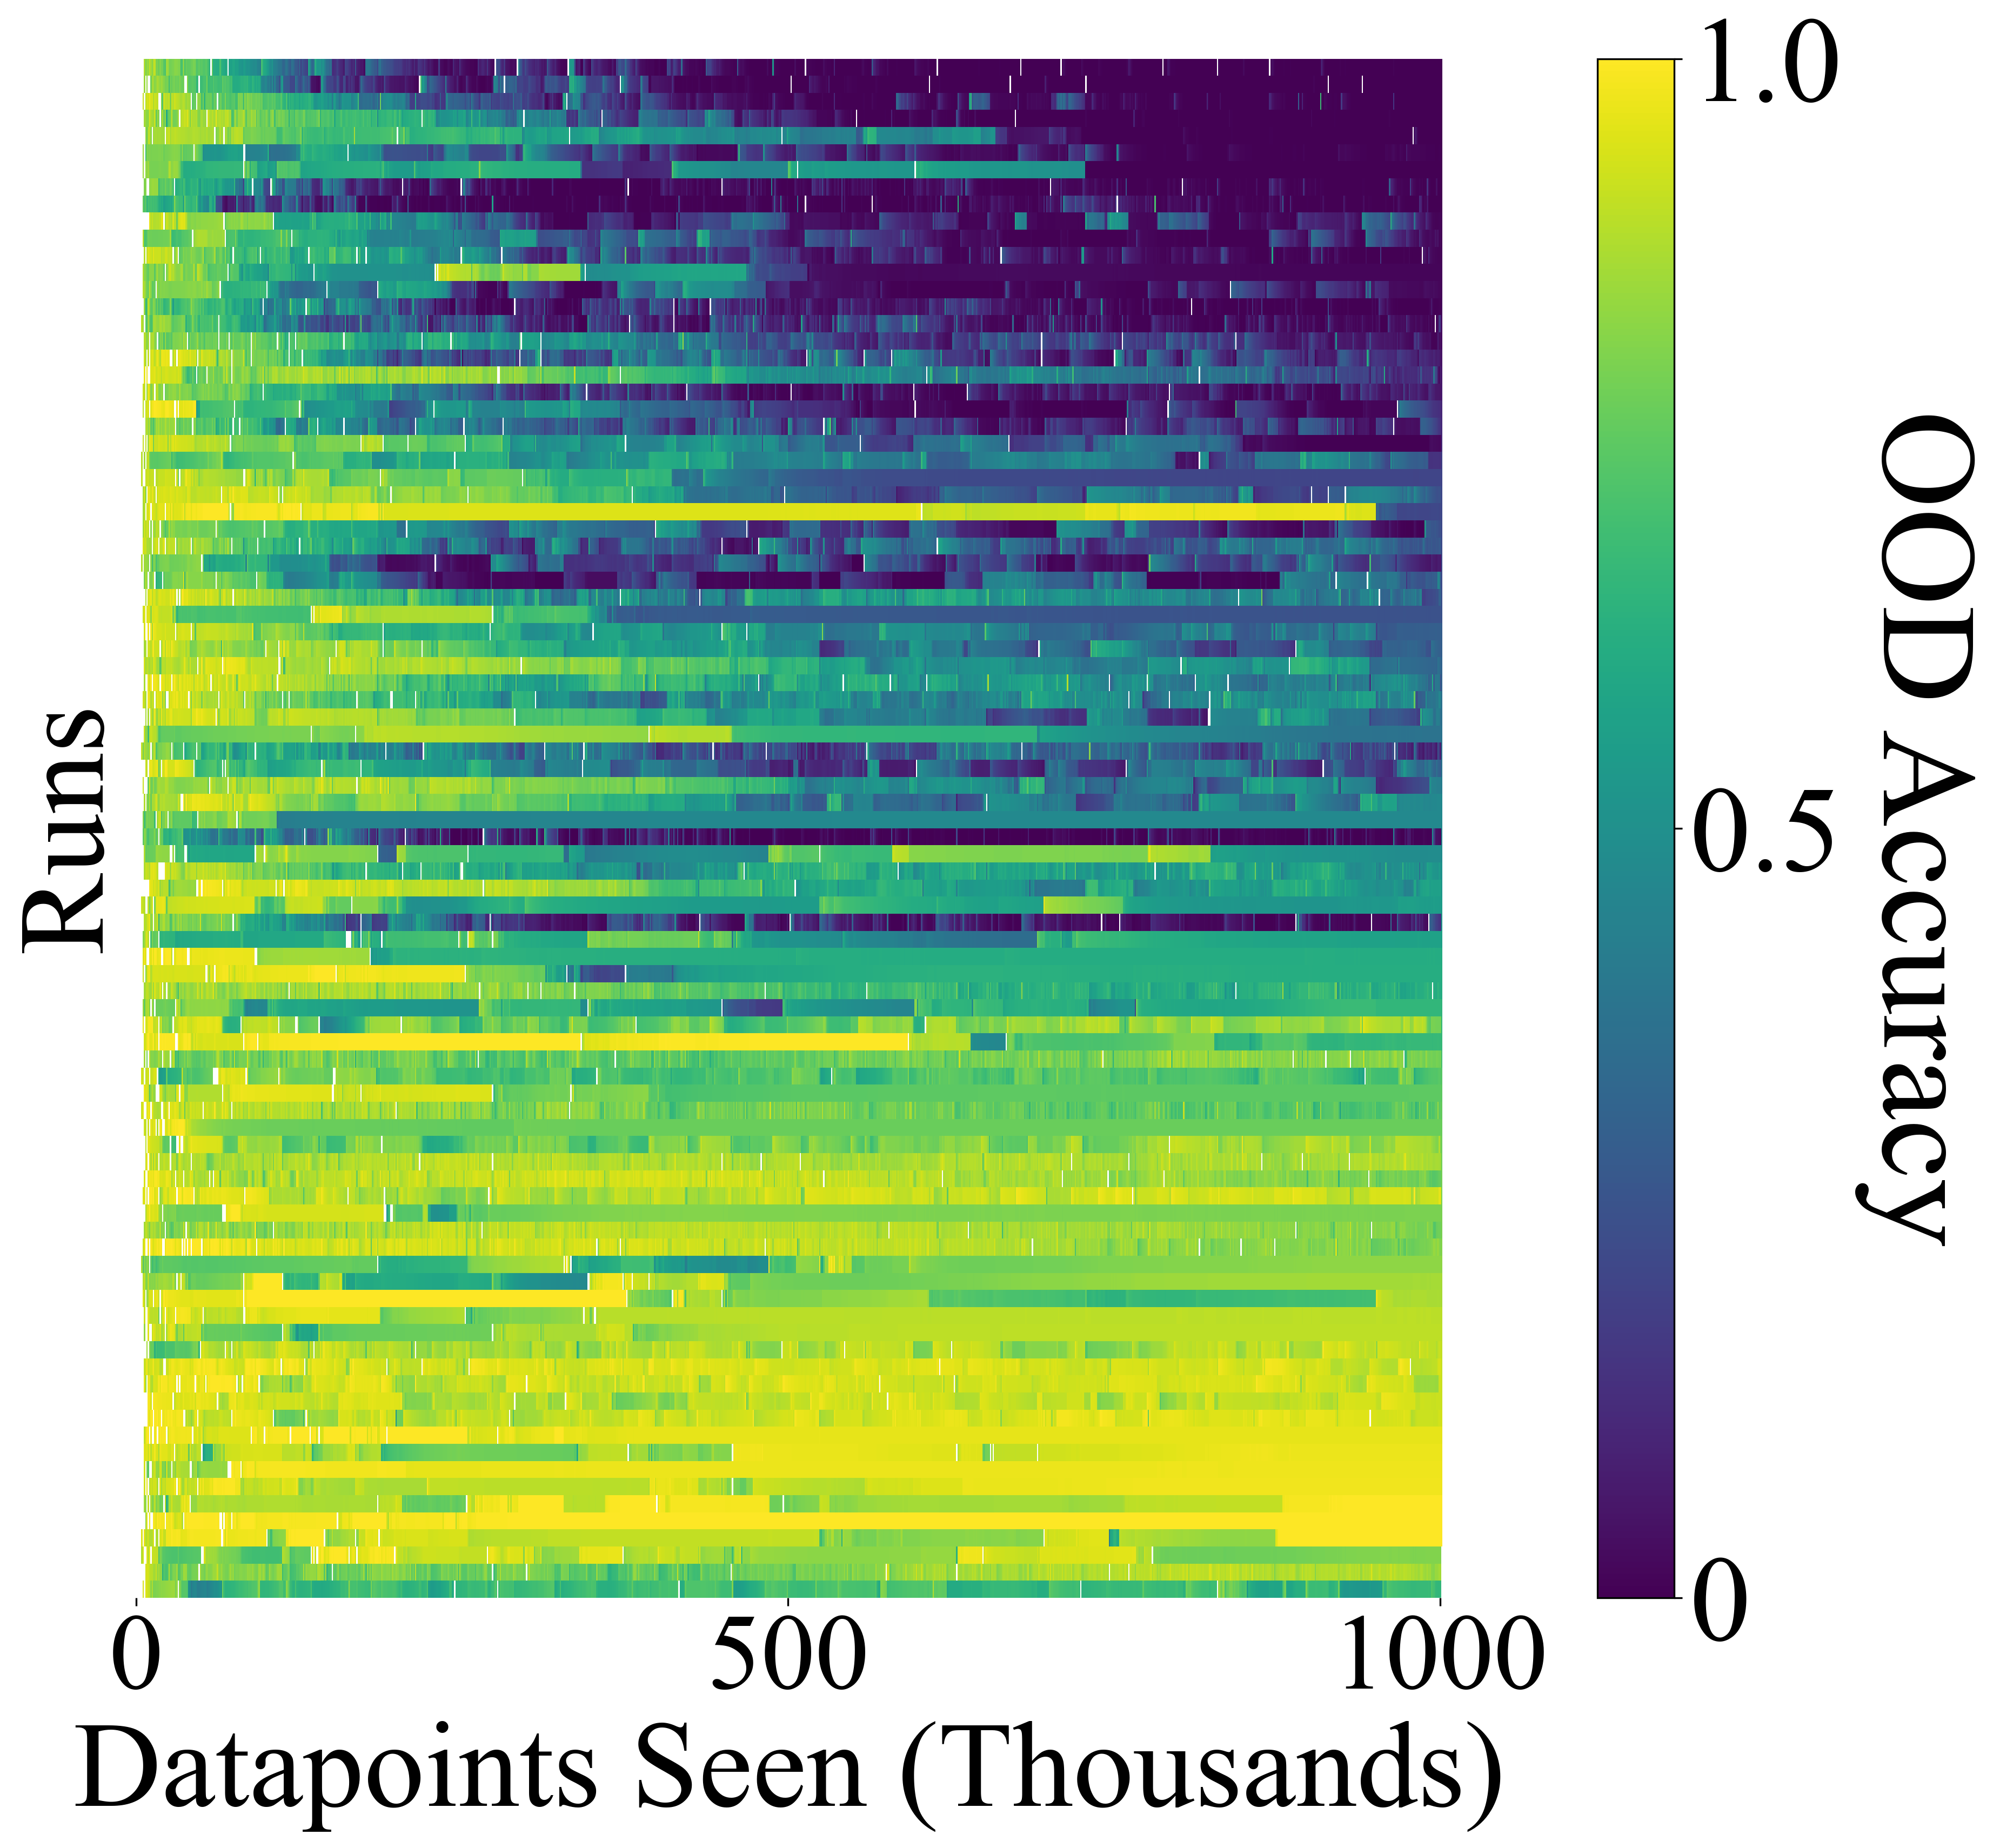

In [11]:
def plot_heatmap(df, height=1150, width=1250, mark_heuristic=False):
    df = df.copy()
    df['ood_test_acc_vector'] = df['ood_test_acc_vector'].astype(str).apply(literal_eval)
    df['indist_test_acc_vector'] = df['indist_test_acc_vector'].astype(str).apply(literal_eval)

    # mask by cutoff
    df['masked_ood_test_acc_vector'] = df.apply(
        lambda r: [acc if ia >= 0.99 else np.nan
                   for acc, ia in zip(r['ood_test_acc_vector'], r['indist_test_acc_vector'])],
        axis=1)
    df["last_ood_test_acc"] = df["masked_ood_test_acc_vector"].apply(lambda v: v[-1] if v else np.nan)

    # sort runs by final accuracy
    df = df.sort_values(by='last_ood_test_acc', ascending=True)
    X = np.array(df['masked_ood_test_acc_vector'].tolist())

    fig, ax = plt.subplots(figsize=(width/100, height/100))

    sns.heatmap(
        X, ax=ax,
        cmap='viridis',
        vmin=0, vmax=1,
        cbar=False,
        yticklabels=False,
        linewidths=0,
        rasterized=True
    )

    ax.set_xlabel('Datapoints Seen (Thousands)', fontsize=54)
    ax.set_ylabel('Runs', fontsize=54)
    ax.set_xticks([0, 500, 1000])
    ax.set_xticklabels([0, 500, 1000], rotation=0, fontsize=48)

    norm_bar = Normalize(vmin=0, vmax=1)
    sm_bar = ScalarMappable(cmap='viridis', norm=norm_bar)
    sm_bar.set_array([])

    cbar = fig.colorbar(
        sm_bar,
        ax=ax,
        pad=0.09
    )
    cbar.set_ticks([0.0, 0.5, 1.0])
    cbar.set_ticklabels(['0', '0.5', '1.0'])
    cbar.set_label('OOD Accuracy', fontsize=60, labelpad=60, rotation=270)
    cbar.ax.tick_params(labelsize=54)
    
    if mark_heuristic:
    # highlight both intervals: Equal-Count (0.0→0.05) and First-Symbol (0.5→0.6)
        intervals = {
            'Equal-Count':  (0.0, 0.05),
            'First-Symbol': (0.5, 0.59),
        }
        xpos = -0.15

        for label, (d0, d1) in intervals.items():
            y0 = (d0 - norm_bar.vmin) / (norm_bar.vmax - norm_bar.vmin)
            h  = (d1 - d0)   / (norm_bar.vmax - norm_bar.vmin)

            box = patches.Rectangle(
                (0, y0),
                1.0,
                h,
                transform=cbar.ax.transAxes,
                edgecolor='magenta',
                facecolor='none',
                linewidth=4,
                clip_on=False,
                zorder=10
            )
            cbar.ax.add_patch(box)

            # label
            cbar.ax.text(
                xpos,
                d0 + 0.17, 
                label,
                rotation=90,
                va='center',
                ha='right',
                color='magenta',
                fontsize=45,
                transform=cbar.ax.transAxes,
                zorder=20
            )

    plt.tight_layout()
    plt.show()

plot_heatmap(transformer_df[(transformer_df["wd"] == 0) & (transformer_df["n_layer"] == 1)], mark_heuristic=True)
plot_heatmap(transformer_df[(transformer_df["n_layer"] == 1)])
plot_heatmap(transformer_df[(transformer_df["n_layer"] == 2)]) 
plot_heatmap(transformer_df[(transformer_df["n_layer"] == 3)])

Max ID Conv DP:  894000.0


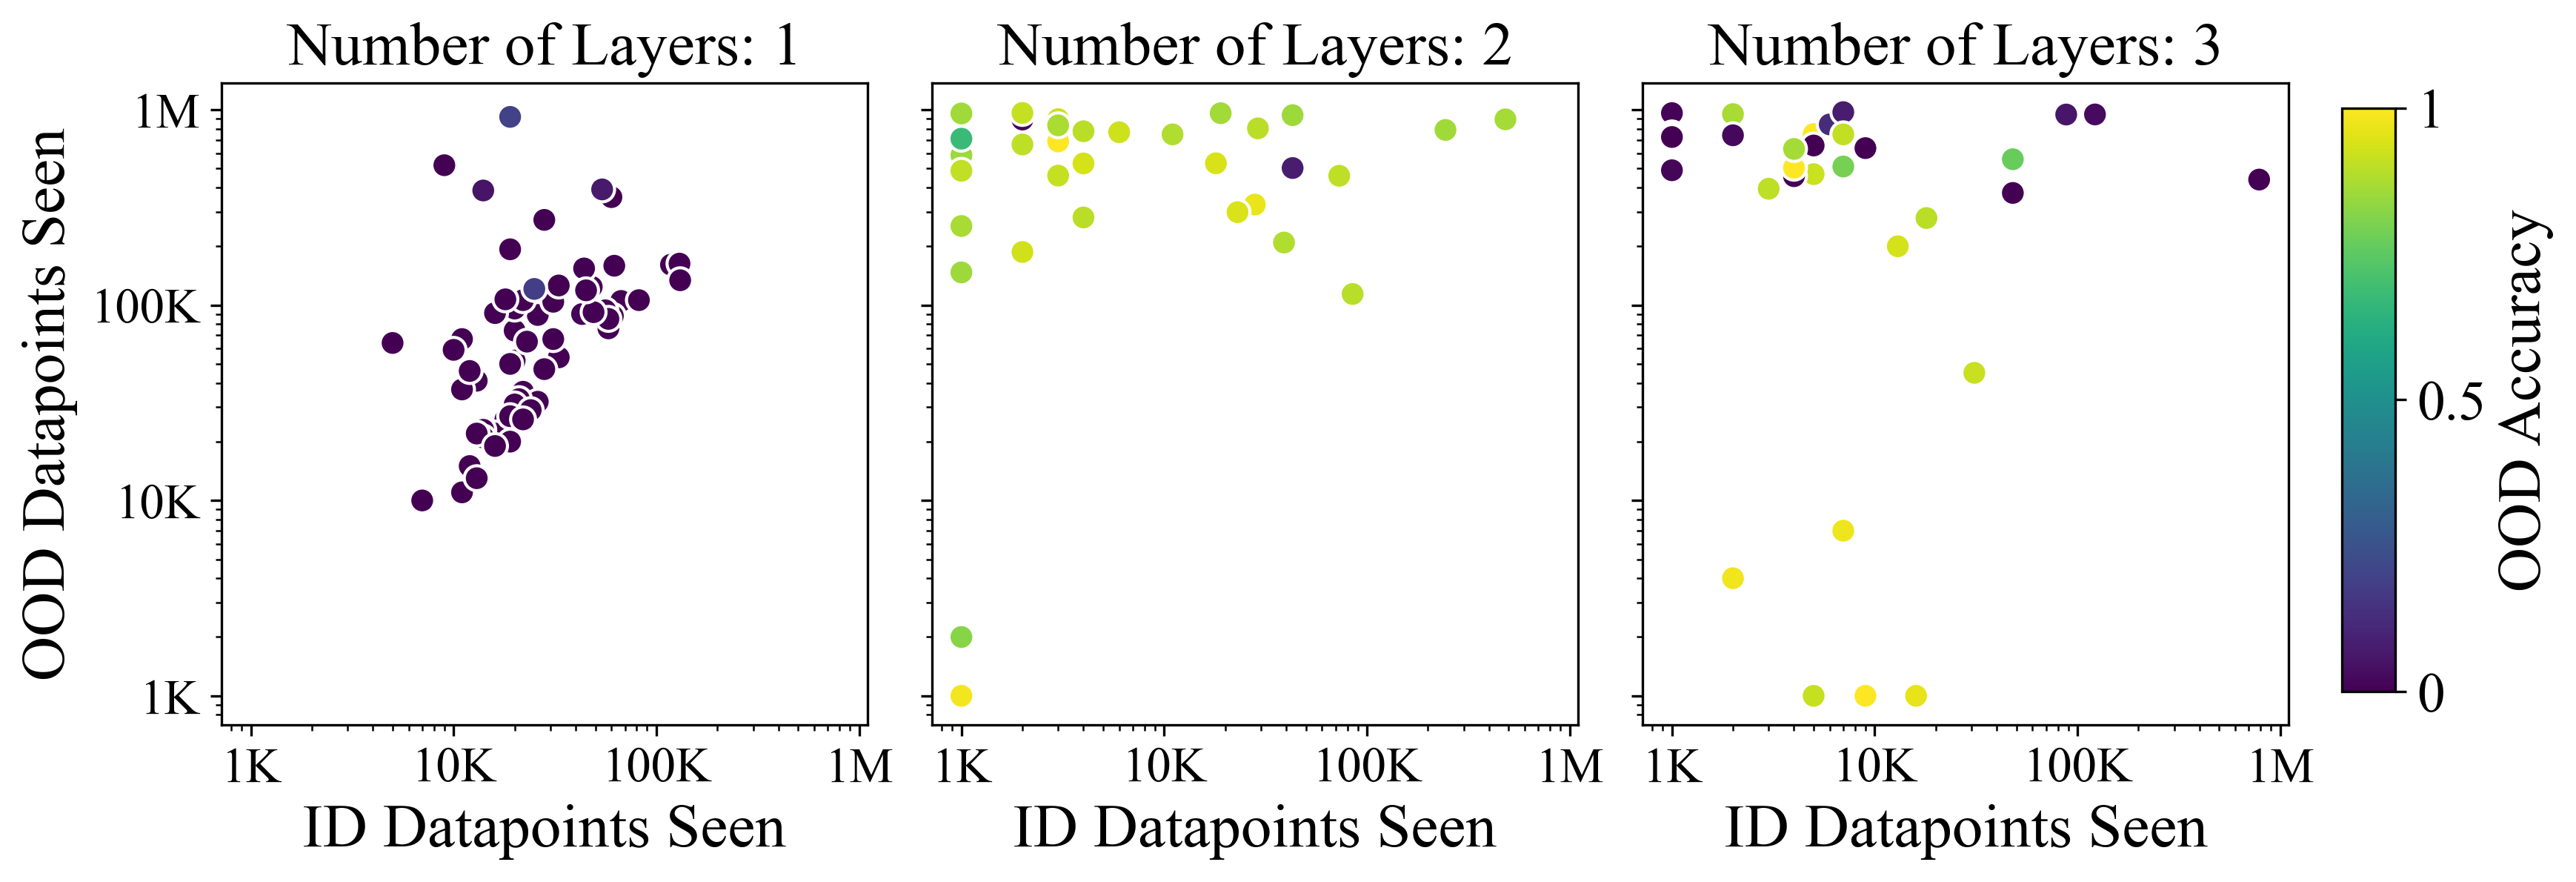

In [12]:
def get_acc_across_training(df):
    df = df.copy()

    def compute_id_conv(acc_vec, dp_vec):
        for i in range(2, len(acc_vec)):
            tail = acc_vec[i:]
            if sum(a >= 0.99 for a in tail) > 0.99 * len(tail):
                return dp_vec[i]
        return dp_vec[-1]

    def compute_ood_conv(acc_vec, dp_vec):
        for i in range(2, len(acc_vec)):
            tail = acc_vec[i:]
            # check if >99% of remaining points are either all <0.2 OR all >0.8
            all_low = sum(a <= 0.2 for a in tail) > 0.99 * len(tail)
            all_high = sum(a >= 0.8 for a in tail) > 0.99 * len(tail)
            if all_low or all_high:
                return dp_vec[i]
        return dp_vec[-1]

    df['id_conv_dp'] = df.apply(
        lambda r: compute_id_conv(r['indist_test_acc_vector'], r['datapoints_seen_vector']), axis=1
    )
    df['ood_conv_dp'] = df.apply(
        lambda r: compute_ood_conv(r['ood_test_acc_vector'], r['datapoints_seen_vector']), axis=1
    )
    print("Max ID Conv DP: ", max(df["id_conv_dp"]))

    df = df[df["ood_conv_dp"] < 975_000]


    layers = sorted(df['n_layer'].unique())
    fig, axes = plt.subplots(
        1, len(layers),
        figsize=(4 * len(layers), 3.75),
        sharex=True, sharey=True
    )


    for ax, n in zip(axes, layers):
        subset = df[df['n_layer'] == n]
        sc = ax.scatter(
            subset['id_conv_dp'],
            subset['ood_conv_dp'],
            c=subset['final_ood_test_acc'],
            cmap='viridis',
            s=65,
            edgecolors='white',
            vmin=0,
            vmax=1,
        )

        ax.set_xscale('log')
        ax.set_yscale('log')

        ticks = [1e3, 1e4, 1e5, 1e6]
        labels = ['1K', '10K', '100K', '1M']

        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels, fontsize=16)
        ax.set_yticklabels(labels, fontsize=16)

        ax.set_xlabel('ID Datapoints Seen', fontsize=20)
        if ax is axes[0]:
            ax.set_ylabel('OOD Datapoints Seen', fontsize=20)
        ax.set_title(f'Number of Layers: {n}', fontsize=20)
        ax.grid(False)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(
        sc,
        cax=cbar_ax,
        label='OOD Accuracy'
    )
    cbar.set_ticks([0, 0.5, 1.0])
    cbar.set_ticklabels(['0', '0.5', '1'], fontsize=18)
    cbar.set_label('OOD Accuracy', fontsize=20)

    plt.subplots_adjust(right=0.90, wspace=0.1)
    plt.show()

get_acc_across_training(transformer_df)